# A1

In [1]:
import pandas as pd

df_hugging = pd.read_csv("hf://datasets/DominusTea/GreekLegalSum/hugginface_dataset.csv")

In [2]:
# Προβολή βασικών πληροφοριών
print("Σχήμα του DataFrame:", df_hugging.shape)
print("\nΟνόματα Στηλών:", df_hugging.columns)
print("\nΤύποι δεδομένων:\n", df_hugging.dtypes)
print("\nΠρώτες γραμμές:\n", df_hugging.head(1))

# Έλεγχος για null τιμές
print("\nΠλήθος null τιμών ανά στήλη:\n", df_hugging.isnull().sum())
print("\nΠλήθος null τιμών στο text:\n", df_hugging.case_category.isnull().sum())




Σχήμα του DataFrame: (8395, 5)

Ονόματα Στηλών: Index(['text', 'summary', 'case_category', 'case_tags', 'subset'], dtype='object')

Τύποι δεδομένων:
 text              object
summary           object
case_category     object
case_tags         object
subset           float64
dtype: object

Πρώτες γραμμές:
                                                 text  \
0  ΑΡΙΘΜΟΣ 970/2009 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ...   

                                             summary      case_category  \
0  Αίτηση αναίρεσης καταδικαστικής αποφάσεως για ...  Ακυρότητα απόλυτη   

                                           case_tags  subset  
0  Αιτιολογίας επάρκεια, Ακυρότητα απόλυτη, Απάτη...     0.0  

Πλήθος null τιμών ανά στήλη:
 text                0
summary             0
case_category    2097
case_tags        2097
subset              0
dtype: int64

Πλήθος null τιμών στο text:
 2097


# A2

# CRAWLER

In [3]:

import os
import time
import csv
import requests
import pandas as pd
from bs4 import BeautifulSoup
from urllib.parse import parse_qs, urlparse
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# Ρυθμίσεις Selenium
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument("--headless")
driver = webdriver.Chrome(options=chrome_options)

# Αρχική συλλογή ειδών αποφάσεων
href_list = []

try:
    driver.get("https://www.areiospagos.gr/nomologia/apofaseis.asp")
    try:
        WebDriverWait(driver, 5).until(EC.frame_to_be_available_and_switch_to_it((By.NAME, "main")))
    except:
        pass

    links = driver.find_elements(By.TAG_NAME, "a")

    for link in links:
        href = link.get_attribute("href")
        text = link.text.strip()
        if href:
            href_list.append((text, href))
            print(f"Είδος: {text} | Σύνδεσμος: {href}")

finally:
    driver.quit()

# CSV αρχεία
csv_file = "apofaseis_live.csv"
fieldnames = ["ειδος", "αριθμος_αποφασης", "κειμενο"]

# Αν δεν υπάρχει ήδη CSV, δημιουργούμε το αρχείο και γράφουμε τα headers
if not os.path.exists(csv_file):
    with open(csv_file, 'w', newline='', encoding='utf-8-sig') as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()

# Φορτώνουμε ήδη αποθηκευμένες αποφάσεις για αποφυγή διπλών
existing_decisions = set()
if os.path.exists(csv_file):
    df_existing = pd.read_csv(csv_file)
    existing_decisions = set((row['ειδος'] + "_" + str(row['αριθμος_αποφασης'])) for idx, row in df_existing.iterrows())

# --- Επεξεργασία κάθε είδους ---
for kind_text, kind_href in href_list:
    print(f"\n=== Επεξεργασία είδους: {kind_text} ===")

    driver = webdriver.Chrome(options=chrome_options)

    try:
        driver.get(kind_href)
        try:
            WebDriverWait(driver, 5).until(EC.frame_to_be_available_and_switch_to_it((By.NAME, "main")))
        except:
            pass

        decision_links = driver.find_elements(By.TAG_NAME, "a")
        decision_hrefs = [link.get_attribute("href") for link in decision_links if link.get_attribute("href")]

    finally:
        driver.quit()

    print(f"Βρέθηκαν {len(decision_hrefs)} αποφάσεις για το είδος '{kind_text}'.")

    # Αφαιρούμε το πρώτο και το τελευταίο link (επιστροφή κουμπιά)
    if len(decision_hrefs) >= 2:
        decision_hrefs = decision_hrefs[1:-1]
    else:
        # Αν έχει λίγα links, συνεχίζουμε με αυτά που έχει
        pass

    for decision_href in decision_hrefs:
        try:
            parsed_url = urlparse(decision_href)
            query_params = parse_qs(parsed_url.query)
            apof_list = query_params.get('apof', [])
            if apof_list:
                decision_number = apof_list[0]
            else:
                decision_number = "Άγνωστο"

            unique_key = kind_text + "_" + decision_number

            if unique_key in existing_decisions:
                print(f"✅ Απόφαση {decision_number} ({kind_text}) υπάρχει ήδη, παράκαμψη.")
                continue

            print(f"--> Κατέβασμα απόφασης {decision_number} ({kind_text})...")

            # Κατέβασμα απόφασης
            response = requests.get(decision_href)
            response.encoding = 'windows-1253'
            soup = BeautifulSoup(response.text, 'html.parser')

            p_elements = soup.find_all('p')
            html_content = "\n".join([p.decode_contents() for p in p_elements])

            # Αποθήκευση άμεσα στο CSV
            with open(csv_file, 'a', newline='', encoding='utf-8-sig') as f:
                writer = csv.DictWriter(f, fieldnames=fieldnames)
                writer.writerow({
                    "ειδος": kind_text,
                    "αριθμος_αποφασης": decision_number,
                    "κειμενο": html_content
                })

            existing_decisions.add(unique_key)

            time.sleep(0.5)  # μικρό delay για ασφάλεια

        except Exception as e:
            print(f"❌ Σφάλμα στο {decision_href}: {e}")
            time.sleep(1)

# Τελικό μήνυμα
print("\n✅ Ολοκληρώθηκε! Τα δεδομένα αποθηκεύτηκαν στο 'apofaseis.csv'")


'\nimport os\nimport time\nimport csv\nimport requests\nimport pandas as pd\nfrom bs4 import BeautifulSoup\nfrom urllib.parse import parse_qs, urlparse\nfrom selenium import webdriver\nfrom selenium.webdriver.common.by import By\nfrom selenium.webdriver.support.ui import WebDriverWait\nfrom selenium.webdriver.support import expected_conditions as EC\n\n# Ρυθμίσεις Selenium\nchrome_options = webdriver.ChromeOptions()\nchrome_options.add_argument("--headless")\ndriver = webdriver.Chrome(options=chrome_options)\n\n# Αρχική συλλογή ειδών αποφάσεων\nhref_list = []\n\ntry:\n    driver.get("https://www.areiospagos.gr/nomologia/apofaseis.asp")\n    try:\n        WebDriverWait(driver, 5).until(EC.frame_to_be_available_and_switch_to_it((By.NAME, "main")))\n    except:\n        pass\n\n    links = driver.find_elements(By.TAG_NAME, "a")\n\n    for link in links:\n        href = link.get_attribute("href")\n        text = link.text.strip()\n        if href:\n            href_list.append((text, href)

!!! Σας παραθετω μερος του output του crawler για να μην το ξαναατρεχετε γιατι πηρε αρκετη ωρα....!!!

Είδος:  | Σύνδεσμος: https://www.areiospagos.gr/g_custom_search.html
Είδος: Αβάσιμοι_λόγοι | Σύνδεσμος: https://www.areiospagos.gr/nomologia/apofaseis_result.asp?s=2&code=945
Είδος: Αγνώστου_διαμονής_επίδοση | Σύνδεσμος: https://www.areiospagos.gr/nomologia/apofaseis_result.asp?s=2&code=2
Είδος: Αγορανομικός_Κώδικας | Σύνδεσμος: https://www.areiospagos.gr/nomologia/apofaseis_result.asp?s=2&code=161
Είδος: Αγροτικές_κινητοποιήσεις | Σύνδεσμος: https://www.areiospagos.gr/nomologia/apofaseis_result.asp?s=2&code=375
Είδος: Αγροτική_Νομοθεσία | Σύνδεσμος: https://www.areiospagos.gr/nomologia/apofaseis_result.asp?s=2&code=488
Είδος: Αγροτική_φθορά | Σύνδεσμος: https://www.areiospagos.gr/nomologia/apofaseis_result.asp?s=2&code=478
Είδος: Αγροτικός_κλήρος | Σύνδεσμος: https://www.areiospagos.gr/nomologia/apofaseis_result.asp?s=2&code=856
Είδος: Αγροτικών_προϊόντων | Σύνδεσμος: https://www.areiospagos.gr/nomologia/apofaseis_result.asp?s=2&code=41

...

!!!! ΓΡΑΦΕΙ +2 ΓΙΑΤΙ ΜΕΤΡΑΕΙ ΚΑΙ ΤΟΥΣ ΔΥΟ ΣΥΝΔΕΣΜΟΥΣ ΕΠΙΣΤΡΟΦΗ, ΕΠΙΣΤΡΕΦΕΙ ΟΜΩΣ ΤΟΝ ΚΑΝΟΝΙΚΟ ΑΡΙΘΜΟ !!!

=== Επεξεργασία είδους: Αβάσιμοι_λόγοι ===
Βρέθηκαν 10 αποφάσεις για το είδος 'Αβάσιμοι_λόγοι'.
✅ Απόφαση 1482_2018 (Αβάσιμοι_λόγοι) υπάρχει ήδη, παράκαμψη.
✅ Απόφαση 1484_2018 (Αβάσιμοι_λόγοι) υπάρχει ήδη, παράκαμψη.
✅ Απόφαση 1486_2018 (Αβάσιμοι_λόγοι) υπάρχει ήδη, παράκαμψη.
✅ Απόφαση 1489_2018 (Αβάσιμοι_λόγοι) υπάρχει ήδη, παράκαμψη.
✅ Απόφαση 1499_2018 (Αβάσιμοι_λόγοι) υπάρχει ήδη, παράκαμψη.
✅ Απόφαση 1500_2018 (Αβάσιμοι_λόγοι) υπάρχει ήδη, παράκαμψη.
✅ Απόφαση 1501_2018 (Αβάσιμοι_λόγοι) υπάρχει ήδη, παράκαμψη.
✅ Απόφαση 1502_2018 (Αβάσιμοι_λόγοι) υπάρχει ήδη, παράκαμψη.

=== Επεξεργασία είδους: Αγνώστου_διαμονής_επίδοση ===
Βρέθηκαν 95 αποφάσεις για το είδος 'Αγνώστου_διαμονής_επίδοση'.
✅ Απόφαση 76_2015 (Αγνώστου_διαμονής_επίδοση) υπάρχει ήδη, παράκαμψη.
✅ Απόφαση 621_2015 (Αγνώστου_διαμονής_επίδοση) υπάρχει ήδη, παράκαμψη.
✅ Απόφαση 455_2013 (Αγνώστου_διαμονής_επίδοση) υπάρχει ήδη, παράκαμψη.
✅ Απόφαση 556_2013 (Αγνώστου_διαμονής_επίδοση) υπάρχει ήδη, παράκαμψη.

...

=== Επεξεργασία είδους: Αναγνώριση_ακυρότητας_πειθαρχικής_καταδίκης ===
Βρέθηκαν 3 αποφάσεις για το είδος 'Αναγνώριση_ακυρότητας_πειθαρχικής_καταδίκης'.
--> Κατέβασμα απόφασης 184_2015 (Αναγνώριση_ακυρότητας_πειθαρχικής_καταδίκης)...

=== Επεξεργασία είδους: Αναδασμός ===
Βρέθηκαν 3 αποφάσεις για το είδος 'Αναδασμός'.
--> Κατέβασμα απόφασης 497_2014 (Αναδασμός)...

...

=== Επεξεργασία είδους: Ψυχική_οδύνη ===
Βρέθηκαν 4 αποφάσεις για το είδος 'Ψυχική_οδύνη'.
--> Κατέβασμα απόφασης 444_2014 (Ψυχική_οδύνη)...
--> Κατέβασμα απόφασης 445_2014 (Ψυχική_οδύνη)...


In [4]:

import csv
import time
from urllib.parse import urljoin
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# --- Ρυθμίσεις για headless Chrome ---
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument("--headless")
driver = webdriver.Chrome(options=chrome_options)

try:
    # 1. Άνοιγμα σελίδας αναζήτησης
    driver.get("https://www.areiospagos.gr/nomologia/apofaseis.asp")

    # 2. Περιμένουμε να φορτώσει το πεδίο έτους
    wait = WebDriverWait(driver, 10)
    etos_input = wait.until(EC.presence_of_element_located((By.NAME, "x_ETOS")))

    # 3. Συμπληρώνουμε το έτος
    etos_input.clear()
    etos_input.send_keys("2024")
    time.sleep(1)

    # 4. Πατάμε "Αναζήτηση"
    search_button = driver.find_element(By.NAME, "submit_krit")
    search_button.click()
    time.sleep(3)

    # 5. Απόσπαση των links αποφάσεων από την πρώτη σελίδα
    base_url = "https://www.areiospagos.gr/nomologia/"
    links = driver.find_elements(By.TAG_NAME, "a")
    apof_links = []

    for link in links:
        href = link.get_attribute("href")
        if href and "apofaseis_DISPLAY.asp" in href:
            full_url = urljoin(base_url, href)
            apof_links.append(full_url)

    print(f"\n🔗 Βρέθηκαν {len(apof_links)} αποφάσεις για το 2024 στην 1η σελίδα.\n")

    # 6. Για κάθε απόφαση, κάνουμε scraping με requests + σωστό encoding
    data = []
    for i, link in enumerate(apof_links):
        try:
            response = requests.get(link)
            response.encoding = 'windows-1253'  # ✅ Κρίσιμο για σωστά ελληνικά

            soup = BeautifulSoup(response.text, 'html.parser')
            paragraphs = soup.find_all('p')
            texts = []
            for p in paragraphs:
                if p.get_text(strip=True):
                    texts.append(p.decode_contents())
            full_text = "\n".join(texts)

            data.append({
                "link": link,
                "keimeno": full_text
            })

            print(f"[{i+1}/{len(apof_links)}] ✔️ Εξήχθη απόφαση από {link}")

        except Exception as e:
            print(f"[{i+1}] ❌ Σφάλμα σε {link}: {e}")

    # 7. Αποθήκευση σε CSV στον φάκελο Downloads
    csv_path = "apofaseis_2024_periexomeno.csv"
    with open(csv_path, mode="w", newline='', encoding="utf-8-sig") as file:
        writer = csv.DictWriter(file, fieldnames=["link", "keimeno"])
        writer.writeheader()
        for row in data:
            writer.writerow(row)

    print(f"\n✅ Όλες οι αποφάσεις του 2024 αποθηκεύτηκαν στο:\n{csv_path}")

finally:
    driver.quit()


'\nimport csv\nimport time\nfrom urllib.parse import urljoin\nimport requests\nfrom bs4 import BeautifulSoup\nfrom selenium import webdriver\nfrom selenium.webdriver.common.by import By\nfrom selenium.webdriver.support.ui import WebDriverWait\nfrom selenium.webdriver.support import expected_conditions as EC\n\n# --- Ρυθμίσεις για headless Chrome ---\nchrome_options = webdriver.ChromeOptions()\nchrome_options.add_argument("--headless")\ndriver = webdriver.Chrome(options=chrome_options)\n\ntry:\n    # 1. Άνοιγμα σελίδας αναζήτησης\n    driver.get("https://www.areiospagos.gr/nomologia/apofaseis.asp")\n\n    # 2. Περιμένουμε να φορτώσει το πεδίο έτους\n    wait = WebDriverWait(driver, 10)\n    etos_input = wait.until(EC.presence_of_element_located((By.NAME, "x_ETOS")))\n\n    # 3. Συμπληρώνουμε το έτος\n    etos_input.clear()\n    etos_input.send_keys("2024")\n    time.sleep(1)\n\n    # 4. Πατάμε "Αναζήτηση"\n    search_button = driver.find_element(By.NAME, "submit_krit")\n    search_butto

# Load the Dataset extracted from Crawler

In [5]:
import pandas as pd

df = pd.read_csv("apofaseis_live.csv", encoding="utf-8-sig")

# Δείξε τις πρώτες γραμμές
print(df.head())

            ειδος αριθμος_αποφασης  \
0  Αβάσιμοι_λόγοι        1482_2018   
1  Αβάσιμοι_λόγοι        1484_2018   
2  Αβάσιμοι_λόγοι        1486_2018   
3  Αβάσιμοι_λόγοι        1489_2018   
4  Αβάσιμοι_λόγοι        1499_2018   

                                             κειμενο  
0  <a class="blue10_cursor" href="apofaseis.asp" ...  
1  <a class="blue10_cursor" href="apofaseis.asp" ...  
2  <a class="blue10_cursor" href="apofaseis.asp" ...  
3  <a class="blue10_cursor" href="apofaseis.asp" ...  
4  <a class="blue10_cursor" href="apofaseis.asp" ...  


# Διάσπαση της στήλης 'αριθμος_αποφασης' σε δύο νέες στήλες

In [6]:
# Διάσπαση της στήλης 'αριθμος_αποφασης' σε δύο νέες στήλες
df[['αριθμός', 'έτος']] = df['αριθμος_αποφασης'].str.split('_', expand=True)

df['αριθμός'] = df['αριθμός'].astype(int)
df['έτος'] = df['έτος'].astype(int)

# Εμφάνιση για έλεγχο
print(df.head())

            ειδος αριθμος_αποφασης  \
0  Αβάσιμοι_λόγοι        1482_2018   
1  Αβάσιμοι_λόγοι        1484_2018   
2  Αβάσιμοι_λόγοι        1486_2018   
3  Αβάσιμοι_λόγοι        1489_2018   
4  Αβάσιμοι_λόγοι        1499_2018   

                                             κειμενο  αριθμός  έτος  
0  <a class="blue10_cursor" href="apofaseis.asp" ...     1482  2018  
1  <a class="blue10_cursor" href="apofaseis.asp" ...     1484  2018  
2  <a class="blue10_cursor" href="apofaseis.asp" ...     1486  2018  
3  <a class="blue10_cursor" href="apofaseis.asp" ...     1489  2018  
4  <a class="blue10_cursor" href="apofaseis.asp" ...     1499  2018  


# TΜΗΜΑ ΚΑΙ ΑΡΙΘΜΟΣ ΤΜΗΜΑΤΟΣ

In [7]:
import re

def extract_tmima_arithmos(html):
    # Ενιαία έκφραση που αγνοεί όσα <br/> ακολουθούν μετά από τον τίτλο
    match = re.search(
        r'ΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ΠΑΓΟΥ(?:<br/>\s*)+(.*?)(?:<br/>)',
        html,
        re.IGNORECASE
    )
    return match.group(1).strip() if match else None

# Εφαρμογή στο DataFrame
df['tmima_arithmos'] = df['κειμενο'].apply(extract_tmima_arithmos)

# Προβολή αποτελεσμάτων
print(df[['tmima_arithmos']].head())

     tmima_arithmos
0  Ζ’ ΠΟΙΝΙΚΟ ΤΜΗΜΑ
1  Ζ' ΠΟΙΝΙΚΟ ΤΜΗΜΑ
2  Ζ' ΠΟΙΝΙΚΟ ΤΜΗΜΑ
3  Ζ' ΠΟΙΝΙΚΟ ΤΜΗΜΑ
4   Ζ'ΠΟΙΝΙΚΟ ΤΜΗΜΑ


In [8]:
print(df.tail())

                   ειδος αριθμος_αποφασης  \
20790  Ψευδορκία_μάρτυρα        2642_2008   
20791  Ψευδορκία_μάρτυρα        2664_2008   
20792  Ψευδορκία_μάρτυρα        2683_2008   
20793       Ψυχική_οδύνη         444_2014   
20794       Ψυχική_οδύνη         445_2014   

                                                 κειμενο  αριθμός  έτος  \
20790  <a class="blue10_cursor" href="apofaseis.asp" ...     2642  2008   
20791  <a class="blue10_cursor" href="apofaseis.asp" ...     2664  2008   
20792  <a class="blue10_cursor" href="apofaseis.asp" ...     2683  2008   
20793  <a class="blue10_cursor" href="apofaseis.asp" ...      444  2014   
20794  <a class="blue10_cursor" href="apofaseis.asp" ...      445  2014   

                         tmima_arithmos  
20790  Στ' Ποινικό Τμήμα - Σε Συμβούλιο  
20791                  Z' ΠΟΙΝΙΚΟ ΤΜΗΜΑ  
20792                  Ε' Ποινικό Τμήμα  
20793                 Β2 Πολιτικό Τμήμα  
20794                 Β2 Πολιτικό Τμήμα  


In [9]:
print(df['tmima_arithmos'].isnull().sum())

205


In [10]:
df['tmima_arithmos'] = df['tmima_arithmos'].apply(lambda x: x.upper() if isinstance(x, str) else x)


In [11]:
print(df['tmima_arithmos'].isnull().sum())

205


In [12]:
df.loc[12, 'tmima_arithmos'] = "Ζ' ΠΟΙΝΙΚΟ ΤΜΗΜΑ"


In [13]:
import pandas as pd
import unicodedata
import re

# Συνάρτηση καθαρισμού
def clean_text(text):
    text = str(text)
    text = unicodedata.normalize('NFD', text)  # αφαίρεση τόνων
    text = ''.join(c for c in text if unicodedata.category(c) != 'Mn')
    latin_to_greek = str.maketrans("ABEZHKMNOPTYX", "ΑΒΕΖΗΚΜΝΟΡΤΥΧ")
    text = text.translate(latin_to_greek)      # μετατροπή λατινικών σε ελληνικά
    text = text.upper()                        # όλα κεφαλαία
    text = re.sub(r"[-–—]+", " ", text)        # παύλες σε space
    text = re.sub(r"[\"'()]", "", text)        # εισαγωγικά, παρενθέσεις
    text = re.sub(r"\s+", " ", text)           # πολλά κενά → 1
    text = text.strip()                        # αφαίρεση περιθωρίων
    # Επέκταση συντομογραφιών
    text = text.replace("ΠΟΙΝ.", "ΠΟΙΝΙΚΟ").replace("ΠΟΛΙ.", "ΠΟΛΙΤΙΚΟ")
    text = text.replace("ΤΜΗΜ.", "ΤΜΗΜΑ").replace("ΤΜΗΜ", "ΤΜΗΜΑ")
    text = text.replace("ΤΜΗΜΑΑ", "TMHMA")
    text = text.replace("TMHMA TMHMA", "TMHMA")
    text = text.replace("Α2’ ΠΟΛΙΤΙΚΟ TMHMA", "Α2 ΠΟΛΙΤΙΚΟ TMHMA")
    text = text.replace("Β’ ΠΟΙΝΙΚΟ TMHMA ΔΙΑΚΟΠΩΝ", "Β ΠΟΙΝΙΚΟ TMHMA ΔΙΑΚΟΠΩΝ")
    text = text.replace("Β1ΠΟΛΙΤΙΚΟ TMHMA", "Β1 ΠΟΛΙΤΙΚΟ TMHMA")
    text = text.replace("Β2’ ΠΟΛΙΤΙΚΟ TMHMA", "Β2 ΠΟΛΙΤΙΚΟ TMHMA")
    text = text.replace("Γ’ ΠΟΛΙΤΙΚΟ TMHMA", "Γ ΠΟΛΙΤΙΚΟ TMHMA")
    text = text.replace("ΓΠΟΛΙΤΙΚΟ TMHMA", "Γ ΠΟΛΙΤΙΚΟ TMHMA")
    text = text.replace("Ε’ ΠΟΙΝΙΚΟ TMHMA", "Ε ΠΟΙΝΙΚΟ TMHMA")
    text = text.replace("Ε΄ ΠΟΙΝΙΚΟ TMHMA", "Ε ΠΟΙΝΙΚΟ TMHMA")
    text = text.replace("Ε ΠΟΙΝΙΚΟTMHMA", "Ε ΠΟΙΝΙΚΟ TMHMA")
    text = text.replace("Ε΄ ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ", "Ε ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ")
    text = text.replace("Ε ΠΟΙΝΙΚΟ TMHMA Σ Ε ΣΥΜΒΟΥΛΙΟ", "Ε ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ")
    text = text.replace("Ε’ ΠΟΙΝΙΚΟ TMHMA ΩΣ ΣΥΜΒΟΥΛΙΟ", "Ε ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ")
    text = text.replace("Ε’ ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ", "Ε ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ")
    text = text.replace("Ε ΄ ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ", "Ε ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ")
    text = text.replace("Ζ’ ΠΟΙΝΙΚΟ TMHMA", "Ζ ΠΟΙΝΙΚΟ TMHMA")
    text = text.replace("ΖΠΟΙΝΙΚΟ TMHMA", "Ζ ΠΟΙΝΙΚΟ TMHMA")
    text = text.replace("Ζ ΠΟΙΝΙΚΟTMHMA", "Ζ ΠΟΙΝΙΚΟ TMHMA")
    text = text.replace("Ζ΄ ΠΟΙΝΙΚΟ TMHMA", "Ζ ΠΟΙΝΙΚΟ TMHMA")
    text = text.replace("Ζ’ ΠΟIΝIΚΟ TMHMA", "Ζ ΠΟΙΝΙΚΟ TMHMA")
    text = text.replace("ΖΠΟΙΝΙΚΟTMHMA", "Ζ ΠΟΙΝΙΚΟ TMHMA")
    text = text.replace("Ζ΄ ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ", "Ζ ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ")
    text = text.replace("Ζ’ ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ", "Ζ ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ")
    text = text.replace("Ζ ΠΟΙΝΙΚΟ TMHMA ΩΣ ΣΥΜΒΟΥΛΙΟ", "Ζ ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ")
    text = text.replace("ΖΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ", "Ζ ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ")
    text = text.replace("ΣΤ’ ΠΟΙΝΙΚΟ TMHMA", "ΣΤ ΠΟΙΝΙΚΟ TMHMA")
    text = text.replace("ΣΤ ΠΟΙΝΙΚΟTMHMA", "ΣΤ ΠΟΙΝΙΚΟ TMHMA")
    text = text.replace("ΣΤ΄ ΠΟΙΝΙΚΟ TMHMA", "ΣΤ ΠΟΙΝΙΚΟ TMHMA")
    text = text.replace("ΣΤΠΟΙΝΙΚΟTMHMA", "ΣΤ ΠΟΙΝΙΚΟ TMHMA")
    text = text.replace("ΣΤΠΟΙΝΙΚΟ TMHMA", "ΣΤ ΠΟΙΝΙΚΟ TMHMA")
    text = text.replace("ΣΤ΄ ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ", "ΣΤ ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ")
    text = text.replace("ΣΤΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ", "ΣΤ ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ")
    text = text.replace("ΣΤ΄ ΠΟΙΝIΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ", "ΣΤ ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ")
    text = text.replace("ΣΤ ΠΟΙΝΙΚΟ TMHMA ΩΣ ΣΥΜΒΟΥΛΙΟ", "ΣΤ ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ")
    text = text.replace("ΣΤ’ ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ", "ΣΤ ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ")
    text = text.replace("ΣΤΠΟΙΝΙΚΟTMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ", "ΣΤ ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ")

    # Αντικατάσταση των διάφορων μορφών με την επιθυμητή
    text = re.sub(r"(Α[’΄]?\s?ΠΟΙΝΙΚΟ\s?)TMHMA\s?ΔΙΑΚΟΠΩΝ", "Α ΠΟΙΝΙΚΟ ΤΜΗΜΑ ΔΙΑΚΟΠΩΝ", text)

    return text


# Καθαρισμός της στήλης
df['tmima_arithmos']=df['tmima_arithmos'].apply(clean_text)



# Εκτύπωση
print(df)



                   ειδος αριθμος_αποφασης  \
0         Αβάσιμοι_λόγοι        1482_2018   
1         Αβάσιμοι_λόγοι        1484_2018   
2         Αβάσιμοι_λόγοι        1486_2018   
3         Αβάσιμοι_λόγοι        1489_2018   
4         Αβάσιμοι_λόγοι        1499_2018   
...                  ...              ...   
20790  Ψευδορκία_μάρτυρα        2642_2008   
20791  Ψευδορκία_μάρτυρα        2664_2008   
20792  Ψευδορκία_μάρτυρα        2683_2008   
20793       Ψυχική_οδύνη         444_2014   
20794       Ψυχική_οδύνη         445_2014   

                                                 κειμενο  αριθμός  έτος  \
0      <a class="blue10_cursor" href="apofaseis.asp" ...     1482  2018   
1      <a class="blue10_cursor" href="apofaseis.asp" ...     1484  2018   
2      <a class="blue10_cursor" href="apofaseis.asp" ...     1486  2018   
3      <a class="blue10_cursor" href="apofaseis.asp" ...     1489  2018   
4      <a class="blue10_cursor" href="apofaseis.asp" ...     1499  2018   
...      

In [14]:
print(df.loc[11225, "tmima_arithmos"])
print(df.loc[11225, "ειδος"])
print(df.loc[11225, "αριθμος_αποφασης"])
df.loc[11225, 'tmima_arithmos'] = "Β2 ΠΟΛΙΤΙΚΟ TMHMA"
print(df.loc[11225, "tmima_arithmos"])
print(df.loc[11225, "ειδος"])
print(df.loc[11225, "αριθμος_αποφασης"])


print(df.loc[12567, "tmima_arithmos"])
print(df.loc[12567, "ειδος"])
print(df.loc[12567, "αριθμος_αποφασης"])
df.loc[12567, 'tmima_arithmos'] = "Ζ ΠΟΙΝΙΚΟ TMHMA"
print(df.loc[12567, "tmima_arithmos"])
print(df.loc[12567, "ειδος"])
print(df.loc[12567, "αριθμος_αποφασης"])


print(df.loc[20208, "tmima_arithmos"])
print(df.loc[20208, "ειδος"])
print(df.loc[20208, "αριθμος_αποφασης"])
df.loc[20208, 'tmima_arithmos'] = "Β2 ΠΟΛΙΤΙΚΟ TMHMA"
print(df.loc[20208, "tmima_arithmos"])
print(df.loc[20208, "ειδος"])
print(df.loc[20208, "αριθμος_αποφασης"])

2 ΠΟΛΙΤΙΚΟ TMHMA
Εργατικό_ατύχημα
179_2015
Β2 ΠΟΛΙΤΙΚΟ TMHMA
Εργατικό_ατύχημα
179_2015
Ζ
Εφέσεως_απαράδεκτο
557_2013
Ζ ΠΟΙΝΙΚΟ TMHMA
Εφέσεως_απαράδεκτο
557_2013
2 ΠΟΛΙΤΙΚΟ TMHMA
Χρηματική_ικανοποίηση
179_2015
Β2 ΠΟΛΙΤΙΚΟ TMHMA
Χρηματική_ικανοποίηση
179_2015


In [15]:
df['tmima'] = df['tmima_arithmos'].apply(
    lambda x: 'ΠΟΙΝΙΚΟ' if 'ΠΟΙΝΙΚΟ' in x or 'ΠΟΙΝ.' in x or 'ΠΟΙΝΙΚ' in x else ('ΠΟΛΙΤΙΚΟ' if 'ΠΟΛΙΤΙΚΟ' in x or 'ΠΟΛΙΤ.' in x or 'ΠΟΛΙΤΙΚ' in x else '')
)

# Print the result
print(df.tmima)
print(df['tmima_arithmos'].isnull().sum())
print(df['tmima'].isnull().sum())

0         ΠΟΙΝΙΚΟ
1         ΠΟΙΝΙΚΟ
2         ΠΟΙΝΙΚΟ
3         ΠΟΙΝΙΚΟ
4         ΠΟΙΝΙΚΟ
           ...   
20790     ΠΟΙΝΙΚΟ
20791     ΠΟΙΝΙΚΟ
20792     ΠΟΙΝΙΚΟ
20793    ΠΟΛΙΤΙΚΟ
20794    ΠΟΛΙΤΙΚΟ
Name: tmima, Length: 20795, dtype: object
0
0


In [16]:


# Ορισμός των αποδεκτών αριθμών τμημάτων
valid_tmimata = ['Α', 'Β', 'Γ', 'Δ', 'Ε', 'ΣΤ', 'Ζ', 'Α1', 'Α2', 'Β1', 'Β2']

# Συνάρτηση εξαγωγής του αριθμού τμήματος
def extract_tmima(text):
    if pd.isna(text):
        return None
    # Πάρε μόνο το πρώτο "λέξη" πριν το κενό
    first_token = re.match(r"^[Α-Ω0-9΄']+", text.strip())
    if first_token:
        token = first_token.group(0).replace("΄", "").replace("'", "")
        if token in valid_tmimata:
            return token
    return None

# Δημιουργία νέας στήλης
df['arithmos_tmimatos'] = df['tmima_arithmos'].apply(extract_tmima)
print (df['arithmos_tmimatos'])

0         Ζ
1         Ζ
2         Ζ
3         Ζ
4         Ζ
         ..
20790    ΣΤ
20791     Ζ
20792     Ε
20793    Β2
20794    Β2
Name: arithmos_tmimatos, Length: 20795, dtype: object


In [17]:
import numpy as np

df.replace(['NONE', 'ΝONE', 'None', 'Νone',""], np.nan, inplace=True)
print(df['arithmos_tmimatos'].isnull().sum())
print(df['tmima'].isnull().sum())

413
209


# ΔΙΚΑΣΤΕΣ


In [18]:
def extract_dikastes(html):
    match = re.search(r'Συγκροτήθηκε από τους Δικαστές:\s*(.*?)<br/>', html, re.DOTALL)
    return match.group(1).strip() if match else None

df['dikastes'] = df['κειμενο'].apply(extract_dikastes)
print (df['dikastes'])

0        Γεώργιο Σακκά, Αντιπρόεδρο του Αρείου Πάγου, Β...
1        Γεώργιο Σακκά, Αντιπρόεδρο του Αρείου Πάγου, Β...
2        Γεώργιο Σακκά, Αντιπρόεδρο του Αρείου Πάγου, Δ...
3        Γεώργιο Σακκά, Αντιπρόεδρο του Αρείου Πάγου, Δ...
4        Γεώργιο Σακκά, Αντιπρόεδρο του Αρείου Πάγου, Δ...
                               ...                        
20790    Εμμανουήλ Καλούδη, Αντιπρόεδρο Αρείου Πάγου, Α...
20791    Γρηγόριο Μάμαλη, Αντιπρόεδρο Αρείου Πάγου, Νικ...
20792    Κωνσταντίνο Κούκλη, Αντιπρόεδρο Αρείου Πάγου, ...
20793                                                 None
20794                                                 None
Name: dikastes, Length: 20795, dtype: object


In [19]:
print(df['dikastes'].isnull().sum())

1728


# ΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ΠΑΓΟΥ 
(και το εισαγωγικό κείμενο που ακολουθεί)

In [20]:
import re

def extract_areios_pagos(html):
    match = re.search(r'<br/>\s*ΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ΠΑΓΟΥ\s*<br/>(.*?)ΣΚΕΦΘΗΚΕ ΣΥΜΦΩΝΑ ΜΕ ΤΟ ΝΟΜΟ', html, re.DOTALL)
    if match:
        return match.group(1).strip()
    else:
        match = re.search(
        r'<br/>\s*ΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ΠΑΓΟΥ(.*?)<br/>\s*\n*\s*ΣΚΕΦΤΗΚΕ ΣΥΜΦΩΝΑ ΜΕ ΤΟ ΝΟΜΟ',
        html, re.DOTALL | re.IGNORECASE)
        if match:
            return match.group(1).strip()
        else:
            return None


df['areios_pagos'] = df['κειμενο'].apply(extract_areios_pagos)
print(df['areios_pagos'])

print(df['areios_pagos'].isnull().sum())

0        <br/>\nΖ’ ΠΟΙΝΙΚΟ ΤΜΗΜΑ <br/>\n<br/>\nΣυγκροτή...
1        <br/>\nΖ' ΠΟΙΝΙΚΟ ΤΜΗΜΑ <br/>\n<br/>\nΣυγκροτή...
2        <br/>\nΖ' ΠΟΙΝΙΚΟ ΤΜΗΜΑ <br/>\n<br/>\nΣυγκροτή...
3        <br/>\nΖ' ΠΟΙΝΙΚΟ ΤΜΗΜΑ <br/>\n<br/>\nΣυγκροτή...
4        <br/>\nΖ'ΠΟΙΝΙΚΟ ΤΜΗΜΑ <br/>\n<br/>\nΣυγκροτήθ...
                               ...                        
20790    <br/>\nΣτ' Ποινικό Τμήμα - Σε Συμβούλιο<br/>\n...
20791    <br/>\nZ' ΠΟΙΝΙΚΟ ΤΜΗΜΑ  <br/>\n<br/>\nΣυγκροτ...
20792    <br/>\nΕ' Ποινικό Τμήμα  <br/>\n<br/>\nΣυγκροτ...
20793    <br/>\nΒ2 Πολιτικό Τμήμα <br/>\n<br/>\nΣΥΓΚΡΟΤ...
20794    <br/>\nΒ2 Πολιτικό Τμήμα <br/>\n<br/>\nΣΥΓΚΡΟΤ...
Name: areios_pagos, Length: 20795, dtype: object
216


# ΣΚΕΦΘΗΚΕ ΣΥΜΦΩΝΑ ΜΕ ΤΟ ΝΟΜΟ

In [21]:
def extract_skeftike(html):
    match = re.search(
    r"(ΣΚΕΦ[ΤΘ]ΗΚΕ ΣΥΜΦΩΝΑ ΜΕ ΤΟ ΝΟΜΟ(?:<br\s*/?>)*)"
    r"(.*?)"
    r"((?:<br\s*/?>)*ΓΙΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ)",
    html, re.DOTALL | re.IGNORECASE)
    if match : 
        return match.group(2).strip()
    else:
        match = re.search(r"\s*ΣΚΕΦ[ΤΘ]ΗΚΕ ΣΥΜΦΩΝΑ ΜΕ ΤΟ ΝΟΜΟ\s*(?:<br\s*/?>)*\s*(.*?)\s*(?=<br\s*/?>\s*(ΓΙΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ|ΔΙΑ ΤΑΥΤΑ|Για τους λόγους αυτούς))", html, re.DOTALL | re.IGNORECASE)
        if match:
          return match.group(1).strip()
        else:
            return None
       

df['skeftike'] = df['κειμενο'].apply(extract_skeftike)
print(df['skeftike'])

print(df['skeftike'].isnull().sum())


0        Κατά το άρθρο 513 παρ.1 εδ. γ’ του Κ.Ποιν.Δ., ...
1        Κατά το άρθρο 386 παρ. 1 του Π.Κ., το έγκλημα ...
2        Η κρινόμενη αίτηση αναιρέσεως, η οποία ασκήθηκ...
3        Κατά το άρθρο 79 παρ. 1 του Ν. 5960/1933 "περί...
4        Κατά τις διατάξεις του άρθρου 476 παρ. 1 και 2...
                               ...                        
20790    <br/>\nΤο Συμβούλιο Πλημμελειοδικών Αθηνών, με...
20791    <br/>\n Υπαίτιος των πράξεων που προβλέπονται,...
20792    <br/>\n  Ι. Από τις διατάξεις του άρθρου 224 π...
20793    1.<br/>\nΚατά τη διάταξη του άρθρου 559 αρ.1 ε...
20794    1.<br/>\nΚατά τη διάταξη του άρθρου 559 αρ.1 ε...
Name: skeftike, Length: 20795, dtype: object
242


# ΓΙΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ

In [22]:
def extract_logous(html):
    match = re.search(r"(ΓΙΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ|Για τους λόγους αυτούς|ΔΙΑ ΤΑΥΤΑ|Δια ταύτα|ΠΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ)\s*<br/>\s*(.*?)<a class=\"blue10_cursor\"", html, re.DOTALL| re.IGNORECASE)

    if match:
        result = match.group(2).strip()
        return result
    else:
        match = re.search(
        r"ΓΙ\s+Α\s+ΤΟΥΣ\s+ΛΟΓΟΥΣ\s+ΑΥΤΟΥΣ\s*<br/>\s*(.*?)(?=<a\s+class=\"blue10_cursor\")",
        html,
        re.DOTALL| re.IGNORECASE
        )
        if match:
            result = match.group(1).strip()
            return result
        else:
            pattern = r"<br/>\s*Για\s+τους\s+λόγους\s+αυτούς\s+(.*?)(?=<a\s+class=\"blue10_cursor\")"
            match = re.search(pattern, html, re.DOTALL | re.IGNORECASE)
            if match:
                return match.group(1).strip()
            else: 
                pattern = r"(ΓΙΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ|Για τους λόγους αυτούς|ΔΙΑ ΤΑΥΤΑ|Δια ταύτα)\s*:?\s*<br/>\s*(.*?)(?=<a\s+class=\"blue10_cursor\")"
                match = re.search(pattern, html, re.IGNORECASE | re.DOTALL)
                if match:
                    return match.group(2).strip()
                else:
                    pattern = r"(ΓΙΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ|Για τους λόγους αυτούς|ΔΙΑ ΤΑΥΤΑ|Δια ταύτα|ΠΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ)\s*(.*?)(?=<a\s+class=\"blue10_cursor\")"
                    match = re.search(pattern, html, re.IGNORECASE | re.DOTALL)
                    if match:
                        return match.group(2).strip()
                    else:
                        return None


df['logous'] = df['κειμενο'].apply(extract_logous)
print(df['logous'])



0        Συνεκδικάζει την από 19 Απριλίου 2016 αίτηση α...
1        Απορρίπτει την από 23-9-2015 αίτηση αναιρέσεως...
2        Απορρίπτει την από 30-11-2016 αίτηση του κατηγ...
3        ΑΙΤΟΥΜΑΙ Να κηρυχθεί από το Δικαστήριό Σας ως ...
4        Απορρίπτει την από 8-3-2016 αίτηση του κατηγορ...
                               ...                        
20790    Προτείνω όπως απορριφθούν οι 120, 199, 118, 12...
20791    <br/>\nΑναιρεί την υπ' αριθμό 4812/2007 απόφασ...
20792    <br/>\nΑναιρεί την 647/2008 απόφαση του Τριμελ...
20793    ΑΠΟΡΡΙΠΤΕΙ την από 29-7-2013 αίτηση περί αναιρ...
20794    ΑΠΟΡΡΙΠΤΕΙ την από 30-5-2013 αίτηση περί αναιρ...
Name: logous, Length: 20795, dtype: object


In [23]:
print(df['logous'].isnull().sum())

166


# ΑΡΘΡΑ Π.Κ. ΚΑΙ Κ.Π.Δ.

In [24]:
import re
import pandas as pd


# Ορισμός regex pattern
pattern = re.compile(
    r"""
    (
        (?:
            (?:των\s+)?(?:άρθρ(?:ων|ο|ου)?|αρθ\.?|άρθρα)\s+
            (?:
                \d+[α-ωΑ-Ω]?'?
                (?:\s*(?:§|παρ\.?)\s*\d+[α-ωΑ-Ω]?'?)?
                (?:\s*στοιχ\.?\s*[α-ωΑ-Ω](?:['’])?(?:\s*και\s*[α-ωΑ-Ω](?:['’])?)?)?
                (?:\s*περ\.?\s*[α-ωΑ-Ω](?:['’])?)?
                (?:\s*(?:εδ\.?|εδάφιο)\s*[α-ωΑ-Ω](?:['’])?)?
                (?:\s*(?:,|\s*και\s*)\s*)?
            ){1,5}
            \s*(?:του)?\s*
            (?:Π\.?\s?Κ\.?|ΠΚ\.?|ΚΠΔ|ΚΠοινΔ|ΚΠολΔ|
             Π\.?Κ\.?|Κ\.?Π\.?Δ\.?|Κ\.?Ποιν\.?Δ\.?|ΠΚ\.?)
        )
    )
    """,
    re.IGNORECASE | re.VERBOSE
)

# Συνάρτηση εφαρμογής
def extract_references(text):
    if isinstance(text, str):
        matches = pattern.findall(text)
        if matches:
            return "; ".join([m.strip().rstrip(".") for m in matches])
    return None

# Εφαρμογή του regex
indexes_poiniko = df[df["tmima"].str.strip().str.upper() == "ΠΟΙΝΙΚΟ"].index.tolist()

for i in indexes_poiniko:
    df.loc[i, "poiniko_arithmos"] = extract_references(df.loc[i, "κειμενο"])


In [25]:
print(indexes_poiniko)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 130, 131, 132, 133, 319, 320, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416,

In [26]:
print(df.loc[26
        , 'tmima'])
print(df.loc[26
        , 'ειδος'])
print(df.loc[26
        , 'αριθμος_αποφασης'])
print(df.loc[26
        , 'poiniko_arithmos'])

ΠΟΙΝΙΚΟ
Αγνώστου_διαμονής_επίδοση
630_2010
άρθρου 473 παρ. 1 Κ.Ποιν.Δ; άρθρο 476 παρ. 1 και 2 του Κ.Ποιν.Δ; άρθρο 510 παρ. 1 Κ.Ποιν.Δ; άρθρο 139 Κ.Ποιν.Δ; των άρθρων 156 παρ. 1 και 2 του Κ.Ποιν.Δ; άρθρο 273 παρ. 1 Κ.Ποιν.Δ; άρθρου 473 παρ. 1 του Κ.Ποιν.Δ; άρθρου 161 παρ. 1 του Κ.Ποιν.Δ; άρθρου 156 Κ.Ποιν.Δ; άρθρο 156 παρ. 1 Κ.Ποιν.Δ


# ΑΡΘΡΑ Α.Κ. ΚΑΙ Κ. Πολ. Δ.

In [27]:


# Ορισμός regex pattern

import re

pattern = re.compile(
    r"""
    (
        (?:
            (?:των\s+)?(?:άρθρ(?:ων|ο|ου)?|αρθ\.?|άρθρα)\s+
            (?:
                \d+[α-ωΑ-Ω]?'?
                (?:\s*(?:§|παρ\.?)\s*\d+[α-ωΑ-Ω]?'?)?
                (?:\s*στοιχ\.?\s*[α-ωΑ-Ω](?:['’])?(?:\s*και\s*[α-ωΑ-Ω](?:['’])?)?)?
                (?:\s*περ\.?\s*[α-ωΑ-Ω](?:['’])?)?
                (?:\s*(?:εδ\.?|εδάφιο)\s*[α-ωΑ-Ω](?:['’])?)?
                (?:\s*(?:,|\s*και\s*)\s*)?
            ){1,5}
            \s*(?:του)?\s*
            (?:ΚΠολΔ|Κ\.?\s?Πολ\.?\s?Δ|Α\.?Κ\.?|ΑΚ)
        )
    )
    """,
    re.IGNORECASE | re.VERBOSE
)



# Συνάρτηση εφαρμογής
def extract_references(text):
    if isinstance(text, str):
        matches = pattern.findall(text)
        if matches:
            return "; ".join([m.strip().rstrip(".") for m in matches])
    return None

# Εφαρμογή του regex
indexes_politiko = df[df["tmima"].str.strip().str.upper() == "ΠΟΛΙΤΙΚΟ"].index.tolist()

for i in indexes_politiko:
    df.loc[i, "politiko_arithmos"] = extract_references(df.loc[i, "κειμενο"])



# final data cleaning

In [28]:
print(df.columns)

Index(['ειδος', 'αριθμος_αποφασης', 'κειμενο', 'αριθμός', 'έτος',
       'tmima_arithmos', 'tmima', 'arithmos_tmimatos', 'dikastes',
       'areios_pagos', 'skeftike', 'logous', 'poiniko_arithmos',
       'politiko_arithmos'],
      dtype='object')


In [29]:
df.rename(columns={
    'ειδος': 'eidos',
    'αριθμος_αποφασης': 'arithmos_apofasi',
    'κειμενο': 'keimeno',
    'αριθμός': 'arithmos',
    'έτος': 'etos',
}, inplace=True)

#clean the html tags 
from bs4 import BeautifulSoup
def clean_with_bs4(text):
    if text is None:
        return ""
    return BeautifulSoup(text, "html.parser").get_text().strip()

def remove_newlines(text):
    if text is None:
        return ""
    return text.replace('\n', '').replace('\r', '')


#to keimeno to afino me ta html tags giati isos mou xreiastei sta epomena stadia
df['areios_pagos'] = df['areios_pagos'].apply(clean_with_bs4)
df['skeftike'] = df['skeftike'].apply(clean_with_bs4)
df['logous'] = df['logous'].apply(clean_with_bs4)
df['areios_pagos'] = df['areios_pagos'].apply(remove_newlines)
df['skeftike'] = df['skeftike'].apply(remove_newlines)
df['logous'] = df['logous'].apply(remove_newlines)
print (df.areios_pagos)
print(df.skeftike)
print(df.logous)


0        Ζ’ ΠΟΙΝΙΚΟ ΤΜΗΜΑ Συγκροτήθηκε από τους Δικαστέ...
1        Ζ' ΠΟΙΝΙΚΟ ΤΜΗΜΑ Συγκροτήθηκε από τους Δικαστέ...
2        Ζ' ΠΟΙΝΙΚΟ ΤΜΗΜΑ Συγκροτήθηκε από τους Δικαστέ...
3        Ζ' ΠΟΙΝΙΚΟ ΤΜΗΜΑ Συγκροτήθηκε από τους Δικαστέ...
4        Ζ'ΠΟΙΝΙΚΟ ΤΜΗΜΑ Συγκροτήθηκε από τους Δικαστές...
                               ...                        
20790    Στ' Ποινικό Τμήμα - Σε ΣυμβούλιοΣυγκροτήθηκε α...
20791    Z' ΠΟΙΝΙΚΟ ΤΜΗΜΑ  Συγκροτήθηκε από τους Δικαστ...
20792    Ε' Ποινικό Τμήμα  Συγκροτήθηκε από τους Δικαστ...
20793    Β2 Πολιτικό Τμήμα ΣΥΓΚΡΟΤΗΘΗΚΕ από τους δικαστ...
20794    Β2 Πολιτικό Τμήμα ΣΥΓΚΡΟΤΗΘΗΚΕ από τους δικαστ...
Name: areios_pagos, Length: 20795, dtype: object
0        Κατά το άρθρο 513 παρ.1 εδ. γ’ του Κ.Ποιν.Δ., ...
1        Κατά το άρθρο 386 παρ. 1 του Π.Κ., το έγκλημα ...
2        Η κρινόμενη αίτηση αναιρέσεως, η οποία ασκήθηκ...
3        Κατά το άρθρο 79 παρ. 1 του Ν. 5960/1933 "περί...
4        Κατά τις διατάξεις του άρθρου 476 παρ. 1 και 2...
       

# A3

In [30]:
print("Hugging dataframe : ",df_hugging.shape)
print ('My dataframe : ',df.shape )


Hugging dataframe :  (8395, 5)
My dataframe :  (20795, 14)


In [31]:
print("Hugging dataframe : ",df_hugging.isnull().sum())

df_hugging.loc[3,"case_tags"]

Hugging dataframe :  text                0
summary             0
case_category    2097
case_tags        2097
subset              0
dtype: int64


'Αναιρέσεως απόρριψη, Εισαγγελέας Αρείου Πάγου, Έλλειψη ειδικής και εμπεριστατωμένης αιτιολογίας, Αβάσιμοι λόγοι.'

case_category = eidos

In [32]:
print ('My dataframe : ',df.isnull().sum())

My dataframe :  eidos                    0
arithmos_apofasi         0
keimeno                  0
arithmos                 0
etos                     0
tmima_arithmos         205
tmima                  209
arithmos_tmimatos      413
dikastes              1728
areios_pagos             0
skeftike                 0
logous                   0
poiniko_arithmos      1960
politiko_arithmos    19202
dtype: int64


In [33]:
df.poiniko_arithmos

0        άρθρο 513 παρ.1 εδ. γ’ του Κ.Ποιν.Δ; άρθρου 38...
1        άρθρο 386 παρ. 1 του Π.Κ; άρθρου 42 παρ. 1 του...
2        άρθρο 216 παρ. 1 του Π.Κ; άρθρο 386 παρ. 1 του...
3        άρθρου 42 του Κ.Ποιν.Δ; των άρθρων 46 και 42 π...
4        άρθρου 476 παρ. 1 και 2 του Κ.Ποιν.Δ; άρθρο 51...
                               ...                        
20790    άρθρου 386 § 3 εδ. β' Π.Κ; άρθρο 45 ΠΚ; άρθρο ...
20791    άρθρα 229 παρ. 1 και 224 παρ. 2 του ΠΚ; άρθρου...
20792    αρθ. 224 ΠΚ; άρθρου 224 παρ.1 και 2 ΠΚ; άρθρο ...
20793                                                  NaN
20794                                                  NaN
Name: poiniko_arithmos, Length: 20795, dtype: object

# Α4

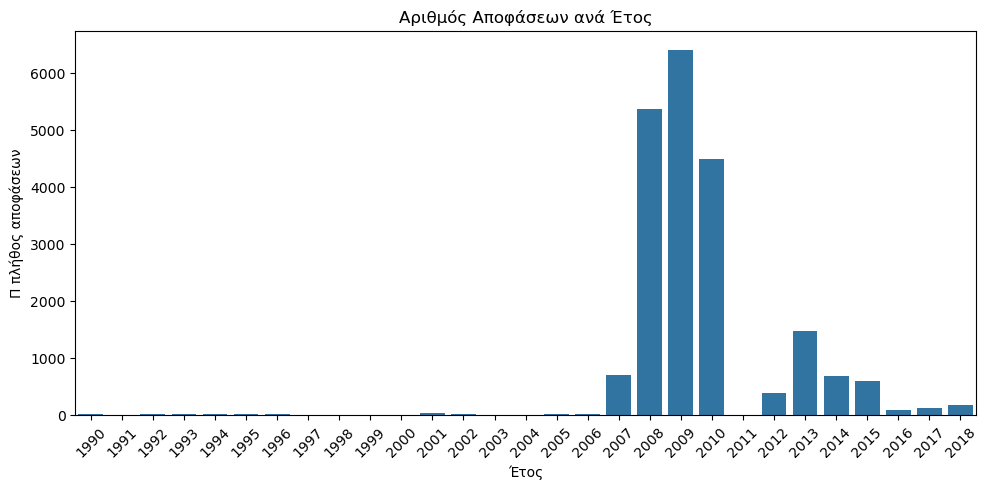

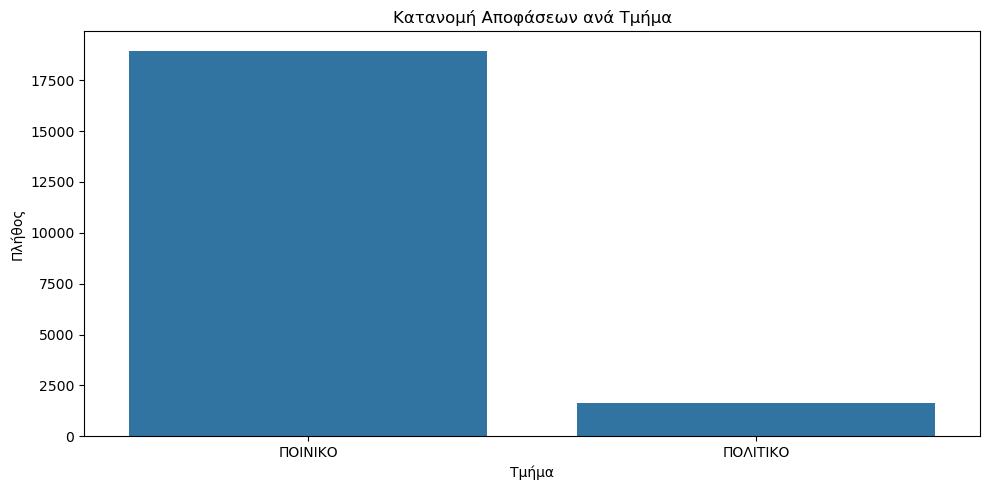

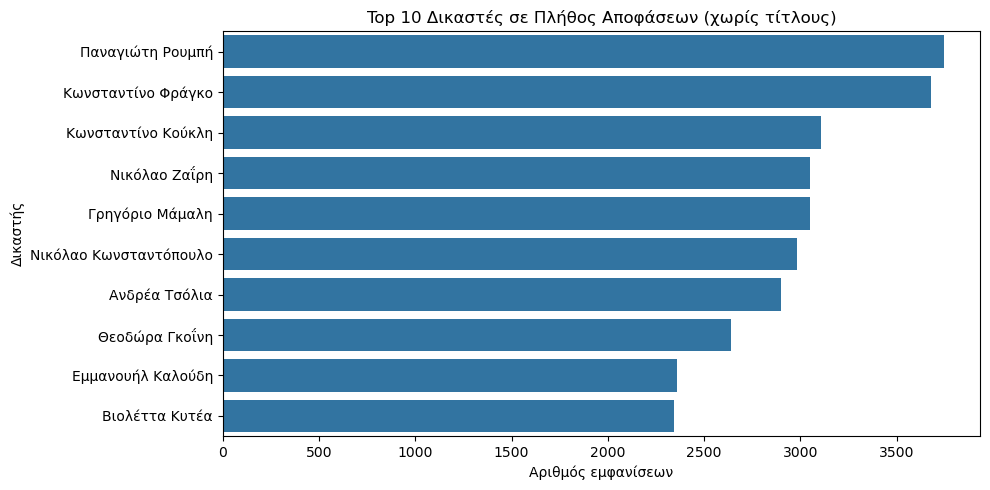

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from collections import Counter



# --- 1. Αριθμός αποφάσεων ανά έτος ---
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="etos", order=sorted(df["etos"].dropna().unique()))
plt.title("Αριθμός Αποφάσεων ανά Έτος")
plt.xlabel("Έτος")
plt.ylabel("Π πλήθος αποφάσεων")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --------------------------------------------------------------------------------

# --- 2. Αποφάσεις ανά τμήμα ---
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="tmima", order=df["tmima"].value_counts().index)
plt.title("Κατανομή Αποφάσεων ανά Τμήμα")
plt.xlabel("Τμήμα")
plt.ylabel("Πλήθος")
plt.tight_layout()
plt.show()


# --------------------------------------------------------------------------------


# --- 3. TOP 10 Άρθρα Π.Κ. και Κ.Π.Δ. για καθε eidos οπου το tmima == ΠΟΙΝΙΚΟ---

# --- Φιλτράρισμα μόνο για ΠΟΙΝΙΚΟ ---
df_poiniko = df[df["tmima"] == "ΠΟΙΝΙΚΟ"].copy()

# Συνάρτηση για υπολογισμό top 10 άρθρων για συγκεκριμένο eidos
def get_top10_articles_by_eidos(selected_eidos):
    filtered_df = df_poiniko[df_poiniko["eidos"] == selected_eidos]
    articles_list = filtered_df["poiniko_arithmos"].dropna().astype(str).str.split(";")
    flat_articles = [item.strip() for sublist in articles_list for item in sublist if item.strip()]
    article_counts = Counter(flat_articles)
    top10 = article_counts.most_common(10)
    return pd.DataFrame(top10, columns=["Άρθρο", "Συχνότητα"]).sort_values("Συχνότητα")

# Πίνακας όλων των διαθέσιμων τιμών στο eidos (μόνο για ΠΟΙΝΙΚΟ)
unique_eidos = df_poiniko["eidos"].dropna().unique()

# Δημιουργία αρχικού γραφήματος για το πρώτο eidos
initial_eidos = unique_eidos[0]
top10_df = get_top10_articles_by_eidos(initial_eidos)

fig = px.bar(
    top10_df,
    x="Συχνότητα",
    y="Άρθρο",
    orientation="h",
    color="Συχνότητα",
    color_continuous_scale="Viridis",
    title=f" Άρθρα Π.Κ. και Κ.Π.Δ. για: {initial_eidos} (μόνο ΠΟΙΝΙΚΟ)",
    labels={"Συχνότητα": "Εμφανίσεις", "Άρθρο": "Άρθρο Π.Κ. και Κ.Π.Δ."}
)

# Προσθήκη dropdown με δυναμικό update
dropdown_buttons = []
for eidos_val in unique_eidos:
    filtered_df = get_top10_articles_by_eidos(eidos_val)
    dropdown_buttons.append(dict(
        method="update",
        label=eidos_val,
        args=[
        {
            "x": [filtered_df["Συχνότητα"]],
            "y": [filtered_df["Άρθρο"]],
            "marker.color": [filtered_df["Συχνότητα"]],
        },
        {
            "title.text": f"Άρθρα Π.Κ. και Κ.Π.Δ. για: {eidos_val} (μόνο ΠΟΙΝΙΚΟ)"
        }
    ]
))

fig.update_layout(
    width=1000,
    height=1000,
    updatemenus=[
        dict(
            active=0,
            buttons=dropdown_buttons,
            direction="down",
            showactive=True,
            x=0.0,
            y=1.15,
            xanchor="left",
            yanchor="top"
        )
    ],
    yaxis=dict(tickfont=dict(size=12)),
    xaxis=dict(title="Πλήθος Εμφανίσεων"),
    plot_bgcolor="white",
    coloraxis_showscale=False
)

fig.show()

# --------------------------------------------------------------------------------


# --- 4. TOP 10 Άρθρα Α.Κ. και Κ.Πολ.Δ. για καθε eidos που το tmima == ΠΟΛΙΤΙΚΟ ---

# --- Φιλτράρισμα μόνο για ΠΟΛΙΤΙΚΟ ---
df_politiko = df[df["tmima"] == "ΠΟΛΙΤΙΚΟ"].copy()

# Συνάρτηση για υπολογισμό top 10 άρθρων για συγκεκριμένο eidos
def get_top10_articles_by_eidos(selected_eidos):
    filtered_df = df_politiko[df_politiko["eidos"] == selected_eidos]
    articles_list = filtered_df["politiko_arithmos"].dropna().astype(str).str.split(";")
    flat_articles = [item.strip() for sublist in articles_list for item in sublist if item.strip()]
    article_counts = Counter(flat_articles)
    top10 = article_counts.most_common(10)
    return pd.DataFrame(top10, columns=["Άρθρο", "Συχνότητα"]).sort_values("Συχνότητα")

# Πίνακας όλων των διαθέσιμων τιμών στο eidos (μόνο για ΠΟΙΝΙΚΟ)
unique_eidos = df_politiko["eidos"].dropna().unique()

# Δημιουργία αρχικού γραφήματος για το πρώτο eidos
initial_eidos = unique_eidos[0]
top10_df = get_top10_articles_by_eidos(initial_eidos)

fig = px.bar(
    top10_df,
    x="Συχνότητα",
    y="Άρθρο",
    orientation="h",
    color="Συχνότητα",
    color_continuous_scale="Viridis",
    title=f" Άρθρα Α.Κ. και Κ.Πολ.Δ. για: {initial_eidos} (μόνο ΠΟΛΙΤΙΚΟ)",
    labels={"Συχνότητα": "Εμφανίσεις", "Άρθρο": "Α.Κ. και Κ.Πολ.Δ."}
)

# Προσθήκη dropdown με δυναμικό update
dropdown_buttons = []
for eidos_val in unique_eidos:
    filtered_df = get_top10_articles_by_eidos(eidos_val)
    dropdown_buttons.append(dict(
        method="update",
        label=eidos_val,
        args=[
        {
            "x": [filtered_df["Συχνότητα"]],
            "y": [filtered_df["Άρθρο"]],
            "marker.color": [filtered_df["Συχνότητα"]],
        },
        {
            "title.text": f"Άρθρα Α.Κ. και Κ.Πολ.Δ. για: {eidos_val} (μόνο ΠΟΛΙΤΙΚΟ)"
        }
    ]
))

fig.update_layout(
    width=1000,
    height=1000,
    updatemenus=[
        dict(
            active=0,
            buttons=dropdown_buttons,
            direction="down",
            showactive=True,
            x=0.0,
            y=1.15,
            xanchor="left",
            yanchor="top"
        )
    ],
    yaxis=dict(tickfont=dict(size=12)),
    xaxis=dict(title="Πλήθος Εμφανίσεων"),
    plot_bgcolor="white",
    coloraxis_showscale=False
)

fig.show()

# --------------------------------------------------------------------------------

# --- 5. Top 10 Δικαστές που εμφανίζονται συχνότερα ---
from collections import Counter
import re

# Λέξεις/φράσεις που θέλουμε να αγνοήσουμε
excluded_terms = [
    "Αρεοπαγίτες",
    "Αντιπρόεδρο Αρείου Πάγου",
    "Αντιπρόεδρο του Αρείου Πάγου"
]

# Διαχωρισμός ονομάτων
all_judges = df["dikastes"].dropna().astype(str).apply(lambda x: re.split(r",| και ", x))

# Φιλτράρισμα και καθαρισμός
flat_judges = [
    j.strip() for sublist in all_judges for j in sublist
    if all(term not in j for term in excluded_terms)
]

# Καταμέτρηση συχνοτήτων
top_judges = Counter(flat_judges).most_common(10)
judges_df = pd.DataFrame(top_judges, columns=["Δικαστής", "Συχνότητα"])

# Οπτικοποίηση
plt.figure(figsize=(10, 5))
sns.barplot(data=judges_df, x="Συχνότητα", y="Δικαστής")
plt.title("Top 10 Δικαστές σε Πλήθος Αποφάσεων (χωρίς τίτλους)")
plt.xlabel("Αριθμός εμφανίσεων")
plt.ylabel("Δικαστής")
plt.tight_layout()
plt.show()



# ΑΠΟΚΛΕΙΣΤΙΚΑ ΓΙΑ ΤΟ ΕΤΟΣ 2024 _  Εφαρμογή όλων των ανωτέρω και στο dataframe με το 2024
Επειδή ο crawler με βάση τις κατηγορίες δεν επιστρέφει καμια απόφαση του 2024 γιατι δεν εχουν κατατχθεί ακόμα σε κατηγορίες, δημιούργησα άλλον ενα crawler αποκλειστικά για τις αποφάσεις του 2024

In [35]:
df_24 = df[df["etos"] == 2024].copy()
print(df_24)

Empty DataFrame
Columns: [eidos, arithmos_apofasi, keimeno, arithmos, etos, tmima_arithmos, tmima, arithmos_tmimatos, dikastes, areios_pagos, skeftike, logous, poiniko_arithmos, politiko_arithmos]
Index: []


In [ ]:

df_2024 = pd.read_csv("apofaseis_2024_periexomeno.csv", encoding="utf-8-sig")


df_2024.head()

,link,keimeno
0,https://www.areiospagos.gr/nomologia/apofaseis...,"<a class=""blue10_cursor"" href=""apofaseis.asp"" ..."
1,https://www.areiospagos.gr/nomologia/apofaseis...,"<a class=""blue10_cursor"" href=""apofaseis.asp"" ..."
2,https://www.areiospagos.gr/nomologia/apofaseis...,"<a class=""blue10_cursor"" href=""apofaseis.asp"" ..."
3,https://www.areiospagos.gr/nomologia/apofaseis...,"<a class=""blue10_cursor"" href=""apofaseis.asp"" ..."
4,https://www.areiospagos.gr/nomologia/apofaseis...,"<a class=""blue10_cursor"" href=""apofaseis.asp"" ..."


In [37]:
from urllib.parse import urlparse, parse_qs

# Δημιουργία της νέας στήλης 'arithmos_apofasi'
df_2024["arithmos_apofasi"] = df_2024["link"].apply(
    lambda url: parse_qs(urlparse(url).query).get("apof", [None])[0]
)

print(df_2024["arithmos_apofasi"])

0       11_2024
1       12_2024
2       13_2024
3       14_2024
4       31_2024
         ...   
2470     6_2024
2471     7_2024
2472     8_2024
2473     1_2024
2474     2_2024
Name: arithmos_apofasi, Length: 2475, dtype: object


In [38]:
# Χώρισε τη στήλη 'arithmos_apofasi' σε δύο νέες στήλες
df_2024[["arithmos", "etos"]] = df_2024["arithmos_apofasi"].str.split("_", expand=True)
df_2024["arithmos"] = df_2024["arithmos"].astype(int)
df_2024["etos"] = df_2024["etos"].astype(int)
print(df_2024["arithmos_apofasi"])
print(df_2024["arithmos"])
print(df_2024["etos"])

0       11_2024
1       12_2024
2       13_2024
3       14_2024
4       31_2024
         ...   
2470     6_2024
2471     7_2024
2472     8_2024
2473     1_2024
2474     2_2024
Name: arithmos_apofasi, Length: 2475, dtype: object
0       11
1       12
2       13
3       14
4       31
        ..
2470     6
2471     7
2472     8
2473     1
2474     2
Name: arithmos, Length: 2475, dtype: int64
0       2024
1       2024
2       2024
3       2024
4       2024
        ... 
2470    2024
2471    2024
2472    2024
2473    2024
2474    2024
Name: etos, Length: 2475, dtype: int64


In [39]:
# Προβολή αποτελεσμάτων
df_2024.loc[1,"keimeno"]

'<a class="blue10_cursor" href="apofaseis.asp" onclick="history.back();return false;">&lt;&lt; Επιστροφή</a>\n\n<br/>\nΑριθμός 12/2024 <br/>\n<br/>\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ΠΑΓΟΥ<br/>\nΒ1\' Πολιτικό Τμήμα <br/>\n<br/>\nΣυγκροτήθηκε από τους δικαστές, Λουκά Μόρφη, Αντιπρόεδρο του Αρείου Πάγου, Δήμητρα Ζώη, Ιωάννα Μαργέλλου-Μπουλταδάκη, Ιωάννη Δουρουκλάκη και Δημητρία Στρούζα-Ξένου, Αρεοπαγίτες.<br/>\n<br/>\nΣυνήλθε σε δημόσια συνεδρίαση στο κατάστημά του, την 1η Φεβρουαρίου 2022, με την παρουσία και της Γραμματέως Ε. Τ., για να δικάσει την υπόθεση, μεταξύ:<br/>\n<br/>\nΤου αναιρεσείοντος: ... (Ν.Π.Ι.Δ.) με την επωνυμία "...", όπως εκπροσωπείται νόμιμα, που εδρεύει στα ... και παραστάθηκε δια δηλώσεως (ΚΠολΔ 242 παρ.2) του πληρεξουσίου δικηγόρου Ευριπίδη Κωνσταντίνου, ο οποίος κατέθεσε προτάσεις.<br/>\nΤου αναιρεσίβλητου: Β. Σ. του Κ., κατοίκου ... που παραστάθηκε δια δηλώσεως (ΚΠολΔ 242 παρ. 2) του πληρεξουσίου δικηγόρου Απόστολου Ανδρεόπουλου, ο οποίος δεν κατέθεσε προτάσεις.<br/>\n<b

In [40]:
import re

def extract_tmima_arithmos(html):
    # Ενιαία έκφραση που αγνοεί όσα <br/> ακολουθούν μετά από τον τίτλο
    match = re.search(
        r'ΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ΠΑΓΟΥ(?:<br/>\s*)+(.*?)(?:<br/>)',
        html,
        re.IGNORECASE
    )
    return match.group(1).strip() if match else None

# Εφαρμογή στο DataFrame
df_2024['tmima_arithmos'] = df_2024['keimeno'].apply(extract_tmima_arithmos)

# Προβολή αποτελεσμάτων
print(df_2024.head(20))

                                                 link  \
0   https://www.areiospagos.gr/nomologia/apofaseis...   
1   https://www.areiospagos.gr/nomologia/apofaseis...   
2   https://www.areiospagos.gr/nomologia/apofaseis...   
3   https://www.areiospagos.gr/nomologia/apofaseis...   
4   https://www.areiospagos.gr/nomologia/apofaseis...   
5   https://www.areiospagos.gr/nomologia/apofaseis...   
6   https://www.areiospagos.gr/nomologia/apofaseis...   
7   https://www.areiospagos.gr/nomologia/apofaseis...   
8   https://www.areiospagos.gr/nomologia/apofaseis...   
9   https://www.areiospagos.gr/nomologia/apofaseis...   
10  https://www.areiospagos.gr/nomologia/apofaseis...   
11  https://www.areiospagos.gr/nomologia/apofaseis...   
12  https://www.areiospagos.gr/nomologia/apofaseis...   
13  https://www.areiospagos.gr/nomologia/apofaseis...   
14  https://www.areiospagos.gr/nomologia/apofaseis...   
15  https://www.areiospagos.gr/nomologia/apofaseis...   
16  https://www.areiospagos.gr/

In [41]:
print(df_2024['tmima_arithmos'].isnull().sum())

18


In [42]:

import unicodedata
import re

# 1. Κάνε όλα τα δεδομένα κεφαλαία
df_2024['tmima_arithmos'] = df_2024['tmima_arithmos'].apply(lambda x: x.upper() if isinstance(x, str) else x)
print("🧼 NaN πριν τον καθαρισμό:", df_2024['tmima_arithmos'].isnull().sum())

# 2. Συνάρτηση καθαρισμού
def clean_text(text):
    text = str(text)
    text = unicodedata.normalize('NFD', text)  # αφαίρεση τόνων
    text = ''.join(c for c in text if unicodedata.category(c) != 'Mn')
    latin_to_greek = str.maketrans("ABEZHKMNOPTYX", "ΑΒΕΖΗΚΜΝΟΡΤΥΧ")
    text = text.translate(latin_to_greek)      # μετατροπή λατινικών σε ελληνικά
    text = text.upper()                        # όλα κεφαλαία
    text = re.sub(r"[-–—]+", " ", text)        # παύλες σε space
    text = re.sub(r"[\"'()]", "", text)        # εισαγωγικά, παρενθέσεις
    text = re.sub(r"\s+", " ", text)           # πολλά κενά → 1
    text = text.strip()                        # αφαίρεση περιθωρίων
    # Επέκταση συντομογραφιών
    text = text.replace("ΠΟΙΝ.", "ΠΟΙΝΙΚΟ").replace("ΠΟΛΙ.", "ΠΟΛΙΤΙΚΟ")
    text = text.replace("ΤΜΗΜ.", "ΤΜΗΜΑ").replace("ΤΜΗΜ", "ΤΜΗΜΑ")
    text = text.replace("ΤΜΗΜΑΑ", "TMHMA")
    text = text.replace("TMHMA TMHMA", "TMHMA")
    text = text.replace("Α2’ ΠΟΛΙΤΙΚΟ TMHMA", "Α2 ΠΟΛΙΤΙΚΟ TMHMA")
    text = text.replace("Β’ ΠΟΙΝΙΚΟ TMHMA ΔΙΑΚΟΠΩΝ", "Β ΠΟΙΝΙΚΟ TMHMA ΔΙΑΚΟΠΩΝ")
    text = text.replace("Β1ΠΟΛΙΤΙΚΟ TMHMA", "Β1 ΠΟΛΙΤΙΚΟ TMHMA")
    text = text.replace("Β2’ ΠΟΛΙΤΙΚΟ TMHMA", "Β2 ΠΟΛΙΤΙΚΟ TMHMA")
    text = text.replace("Γ’ ΠΟΛΙΤΙΚΟ TMHMA", "Γ ΠΟΛΙΤΙΚΟ TMHMA")
    text = text.replace("ΓΠΟΛΙΤΙΚΟ TMHMA", "Γ ΠΟΛΙΤΙΚΟ TMHMA")
    text = text.replace("Ε’ ΠΟΙΝΙΚΟ TMHMA", "Ε ΠΟΙΝΙΚΟ TMHMA")
    text = text.replace("Ε΄ ΠΟΙΝΙΚΟ TMHMA", "Ε ΠΟΙΝΙΚΟ TMHMA")
    text = text.replace("Ε ΠΟΙΝΙΚΟTMHMA", "Ε ΠΟΙΝΙΚΟ TMHMA")
    text = text.replace("Ε΄ ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ", "Ε ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ")
    text = text.replace("Ε ΠΟΙΝΙΚΟ TMHMA Σ Ε ΣΥΜΒΟΥΛΙΟ", "Ε ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ")
    text = text.replace("Ε’ ΠΟΙΝΙΚΟ TMHMA ΩΣ ΣΥΜΒΟΥΛΙΟ", "Ε ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ")
    text = text.replace("Ε’ ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ", "Ε ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ")
    text = text.replace("Ε ΄ ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ", "Ε ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ")
    text = text.replace("Ζ’ ΠΟΙΝΙΚΟ TMHMA", "Ζ ΠΟΙΝΙΚΟ TMHMA")
    text = text.replace("ΖΠΟΙΝΙΚΟ TMHMA", "Ζ ΠΟΙΝΙΚΟ TMHMA")
    text = text.replace("Ζ ΠΟΙΝΙΚΟTMHMA", "Ζ ΠΟΙΝΙΚΟ TMHMA")
    text = text.replace("Ζ΄ ΠΟΙΝΙΚΟ TMHMA", "Ζ ΠΟΙΝΙΚΟ TMHMA")
    text = text.replace("Ζ’ ΠΟIΝIΚΟ TMHMA", "Ζ ΠΟΙΝΙΚΟ TMHMA")
    text = text.replace("ΖΠΟΙΝΙΚΟTMHMA", "Ζ ΠΟΙΝΙΚΟ TMHMA")
    text = text.replace("Ζ΄ ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ", "Ζ ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ")
    text = text.replace("Ζ’ ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ", "Ζ ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ")
    text = text.replace("Ζ ΠΟΙΝΙΚΟ TMHMA ΩΣ ΣΥΜΒΟΥΛΙΟ", "Ζ ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ")
    text = text.replace("ΖΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ", "Ζ ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ")
    text = text.replace("ΣΤ’ ΠΟΙΝΙΚΟ TMHMA", "ΣΤ ΠΟΙΝΙΚΟ TMHMA")
    text = text.replace("ΣΤ ΠΟΙΝΙΚΟTMHMA", "ΣΤ ΠΟΙΝΙΚΟ TMHMA")
    text = text.replace("ΣΤ΄ ΠΟΙΝΙΚΟ TMHMA", "ΣΤ ΠΟΙΝΙΚΟ TMHMA")
    text = text.replace("ΣΤΠΟΙΝΙΚΟTMHMA", "ΣΤ ΠΟΙΝΙΚΟ TMHMA")
    text = text.replace("ΣΤΠΟΙΝΙΚΟ TMHMA", "ΣΤ ΠΟΙΝΙΚΟ TMHMA")
    text = text.replace("ΣΤ΄ ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ", "ΣΤ ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ")
    text = text.replace("ΣΤΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ", "ΣΤ ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ")
    text = text.replace("ΣΤ΄ ΠΟΙΝIΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ", "ΣΤ ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ")
    text = text.replace("ΣΤ ΠΟΙΝΙΚΟ TMHMA ΩΣ ΣΥΜΒΟΥΛΙΟ", "ΣΤ ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ")
    text = text.replace("ΣΤ’ ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ", "ΣΤ ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ")
    text = text.replace("ΣΤΠΟΙΝΙΚΟTMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ", "ΣΤ ΠΟΙΝΙΚΟ TMHMA ΣΕ ΣΥΜΒΟΥΛΙΟ")

    # Αντικατάσταση των διάφορων μορφών με την επιθυμητή
    text = re.sub(r"(Α[’΄]?\s?ΠΟΙΝΙΚΟ\s?)TMHMA\s?ΔΙΑΚΟΠΩΝ", "Α ΠΟΙΝΙΚΟ ΤΜΗΜΑ ΔΙΑΚΟΠΩΝ", text)

    return text

# 3. Εφαρμογή καθαρισμού
df_2024['tmima_arithmos'] = df_2024['tmima_arithmos'].apply(clean_text)

# 4. Δημιουργία στήλης 'tmima'
df_2024['tmima'] = df_2024['tmima_arithmos'].apply(
    lambda x: 'ΠΟΙΝΙΚΟ' if isinstance(x, str) and ('ΠΟΙΝΙΚΟ' in x or 'ΠΟΙΝ.' in x or 'ΠΟΙΝΙΚ' in x)
    else ('ΠΟΛΙΤΙΚΟ' if isinstance(x, str) and ('ΠΟΛΙΤΙΚΟ' in x or 'ΠΟΛΙΤ.' in x or 'ΠΟΛΙΤΙΚ' in x)
    else '')
)

# 5. Έλεγχος
print("\n tmima preview:\n", df_2024["tmima"].value_counts(dropna=False))
print("\n NaN σε tmima_arithmos:", df_2024['tmima_arithmos'].isnull().sum())
print(" NaN σε tmima:", df_2024['tmima'].isnull().sum())


🧼 NaN πριν τον καθαρισμό: 18

 tmima preview:
 tmima
ΠΟΛΙΤΙΚΟ    1707
ΠΟΙΝΙΚΟ      744
              24
Name: count, dtype: int64

 NaN σε tmima_arithmos: 0
 NaN σε tmima: 0


In [43]:
import pandas as pd
import numpy as np
import re

# Ορισμός των αποδεκτών αριθμών τμημάτων
valid_tmimata = ['Α', 'Β', 'Γ', 'Δ', 'Ε', 'ΣΤ', 'Ζ', 'Α1', 'Α2', 'Β1', 'Β2']

# Συνάρτηση εξαγωγής του αριθμού τμήματος
def extract_tmima(text):
    if pd.isna(text):
        return None
    # Πάρε το πρώτο "token" με γράμματα/αριθμούς/τονισμένα
    first_token = re.match(r"^[Α-Ω0-9΄']+", text.strip())
    if first_token:
        token = first_token.group(0).replace("΄", "").replace("'", "")
        if token in valid_tmimata:
            return token
    return None

# Δημιουργία νέας στήλης
df_2024['arithmos_tmimatos'] = df_2024['tmima_arithmos'].apply(extract_tmima)
print(" arithmos_tmimatos:\n", df_2024['arithmos_tmimatos'].unique())

# Καθαρισμός: Αντικατάσταση "κενών" string/typos με np.nan
df_2024.replace(['NONE', 'ΝONE', 'None', 'Νone', ""], np.nan, inplace=True)

# Έλεγχοι
print("\nNaN σε arithmos_tmimatos:", df_2024['arithmos_tmimatos'].isnull().sum())
print(" NaN σε tmima:", df_2024['tmima'].isnull().sum())
print(df_2024["arithmos_tmimatos"])


 arithmos_tmimatos:
 [None 'Β1' 'Β2' 'Α2' 'Γ' 'Δ' 'Α1' 'Ε' 'ΣΤ' 'Α' 'Ζ' 'Β']

NaN σε arithmos_tmimatos: 255
 NaN σε tmima: 24
0       None
1         Β1
2         Β1
3         Β1
4         Β1
        ... 
2470    None
2471    None
2472    None
2473    None
2474    None
Name: arithmos_tmimatos, Length: 2475, dtype: object


In [44]:
def extract_dikastes(html):
    match = re.search(
        r'ΣΥΓΚΡΟΤ.*? από τους(?:\s+Δικαστές)?[,:]?\s*(.*?)(?:<br/>)',
        html,
        re.IGNORECASE | re.DOTALL
    )
    if match:
        return match.group(1).strip()

    match2 = re.search(
        r'αποτελούμενη από\s*(.*?)(?:<br/>)',
        html,
        re.IGNORECASE | re.DOTALL
    )
    if match2:
        return match2.group(1).strip()

    return None





df_2024['dikastes'] = df_2024['keimeno'].apply(extract_dikastes)
print (df_2024['dikastes'])
print(df_2024['dikastes'].isnull().sum())

df_2024.loc[252,"dikastes"]


0       Λουκά Μόρφη, Αντιπρόεδρο του Αρείου Πάγου, Δήμ...
1       Λουκά Μόρφη, Αντιπρόεδρο του Αρείου Πάγου, Δήμ...
2       Ιωάννα Μαργέλλου-Μπουλταδάκη, Προεδρεύουσα Αρε...
3       Ιωάννα Μαργέλλου-Μπουλταδάκη, Προεδρεύουσα Αρε...
4       Δήμητρα Ζώη, Αντιπρόεδρο του Αρείου Πάγου, Αρι...
                              ...                        
2470    Ιωάννα Κλάπα-Χριστοδουλέα, Πρόεδρο του Αρείου ...
2471    Ιωάννα Κλάπα-Χριστοδουλέα, Πρόεδρο του Αρείου ...
2472    Ιωάννα Κλάπα-Χριστοδουλέα, Πρόεδρο του Αρείου ...
2473    την Πρόεδρο του Αρείου Πάγου Ιωάννα Κλάπα-Χρισ...
2474    την Πρόεδρο του Αρείου Πάγου Ιωάννα Κλάπα-Χρισ...
Name: dikastes, Length: 2475, dtype: object
6


'Θεόδωρο Κανελλόπουλο, Αντιπρόεδρο του Αρείου Πάγου, Κυριάκο Μπαμπαλίδη, Παναγιώτη Βενιζελέα, Κλεόβουλο - Δημήτριο Κοκκορό και Ελένη Θεοδωρακοπούλου - Εισηγήτρια, Αρεοπαγίτες.'

In [45]:
import re

def extract_areios_pagos(html):
    match = re.search(r'<br/>\s*ΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ΠΑΓΟΥ\s*<br/>(.*?)ΣΚΕΦΘΗΚΕ ΣΥΜΦΩΝΑ ΜΕ ΤΟ ΝΟΜΟ', html, re.DOTALL)
    if match:
        return match.group(1).strip()
    else:
        match = re.search(
        r'<br/>\s*ΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ΠΑΓΟΥ(.*?)<br/>\s*\n*\s*ΣΚΕΦΤΗΚΕ ΣΥΜΦΩΝΑ ΜΕ ΤΟ ΝΟΜΟ',
        html, re.DOTALL | re.IGNORECASE)
        if match:
            return match.group(1).strip()
        else:
            return None


df_2024['areios_pagos'] = df_2024['keimeno'].apply(extract_areios_pagos)
print(df_2024['areios_pagos'])

print(df_2024['areios_pagos'].isnull().sum())

0                                                    None
1       Β1' Πολιτικό Τμήμα <br/>\n<br/>\nΣυγκροτήθηκε ...
2       Β1' Πολιτικό Τμήμα <br/>\nΣυγκροτήθηκε από του...
3       Β1' Πολιτικό Τμήμα <br/>\nΣυγκροτήθηκε από του...
4       <br/>\nΒ1' Πολιτικό Τμήμα<br/>\n<br/>\nΣυγκροτ...
                              ...                        
2470                                                 None
2471                                                 None
2472                                                 None
2473                                                 None
2474                                                 None
Name: areios_pagos, Length: 2475, dtype: object
35


In [46]:
df_2024.loc[1,"areios_pagos"]

'Β1\' Πολιτικό Τμήμα <br/>\n<br/>\nΣυγκροτήθηκε από τους δικαστές, Λουκά Μόρφη, Αντιπρόεδρο του Αρείου Πάγου, Δήμητρα Ζώη, Ιωάννα Μαργέλλου-Μπουλταδάκη, Ιωάννη Δουρουκλάκη και Δημητρία Στρούζα-Ξένου, Αρεοπαγίτες.<br/>\n<br/>\nΣυνήλθε σε δημόσια συνεδρίαση στο κατάστημά του, την 1η Φεβρουαρίου 2022, με την παρουσία και της Γραμματέως Ε. Τ., για να δικάσει την υπόθεση, μεταξύ:<br/>\n<br/>\nΤου αναιρεσείοντος: ... (Ν.Π.Ι.Δ.) με την επωνυμία "...", όπως εκπροσωπείται νόμιμα, που εδρεύει στα ... και παραστάθηκε δια δηλώσεως (ΚΠολΔ 242 παρ.2) του πληρεξουσίου δικηγόρου Ευριπίδη Κωνσταντίνου, ο οποίος κατέθεσε προτάσεις.<br/>\nΤου αναιρεσίβλητου: Β. Σ. του Κ., κατοίκου ... που παραστάθηκε δια δηλώσεως (ΚΠολΔ 242 παρ. 2) του πληρεξουσίου δικηγόρου Απόστολου Ανδρεόπουλου, ο οποίος δεν κατέθεσε προτάσεις.<br/>\n<br/>\nΗ ένδικη διαφορά άρχισε με την από 6-11-2017 αγωγή του ήδη αναιρεσείοντος, που κατατέθηκε στο Μονομελές Πρωτοδικείο ... Εκδόθηκαν η 81/2018 οριστική απόφαση του πρωτοβαθμίου δικαστ

In [47]:
def extract_skeftike(html):
    match = re.search(
    r"(ΣΚΕΦ[ΤΘ]ΗΚΕ ΣΥΜΦΩΝΑ ΜΕ ΤΟ ΝΟΜΟ(?:<br\s*/?>)*)"
    r"(.*?)"
    r"((?:<br\s*/?>)*ΓΙΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ)",
    html, re.DOTALL | re.IGNORECASE)
    if match : 
        return match.group(2).strip()
    else:
        match = re.search(r"\s*ΣΚΕΦ[ΤΘ]ΗΚΕ ΣΥΜΦΩΝΑ ΜΕ ΤΟ ΝΟΜΟ\s*(?:<br\s*/?>)*\s*(.*?)\s*(?=<br\s*/?>\s*(ΓΙΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ|ΔΙΑ ΤΑΥΤΑ|Για τους λόγους αυτούς))", html, re.DOTALL | re.IGNORECASE)
        if match:
          return match.group(1).strip()
        else:
            return None
       

df_2024['skeftike'] = df_2024['keimeno'].apply(extract_skeftike)
print(df_2024['skeftike'])

print(df_2024['skeftike'].isnull().sum())


0       Από τη διάταξη του άρθρου 80 του KΠολΔ, που ορ...
1       Υπόκειται προς κρίση η από 14-5-2021 (αριθ. εκ...
2       Με την από 16 Ιανουαρίου 2018 και με αριθμό κα...
3       Με την από 2 Νοεμβρίου 2019 και με αριθμό κατά...
4       Με τη διάταξη του άρθρου 576 παρ. 1 του ΚΠολΔ ...
                              ...                        
2470    Κατά το άρθρο 1 εδ.α και β του Ν.3068/2002 'Συ...
2471    Κατά το άρθρο 1 εδ.α, β και γ του Ν. 3068/2002...
2472    Κατά το άρθρο 1 εδ.α, β και γ ν.3068/2002, όπω...
2473                                                 None
2474                                                 None
Name: skeftike, Length: 2475, dtype: object
33


In [48]:
def extract_logous(html):
    match = re.search(r"(ΓΙΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ|Για τους λόγους αυτούς|ΔΙΑ ΤΑΥΤΑ|Δια ταύτα|ΠΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ)\s*<br/>\s*(.*?)<a class=\"blue10_cursor\"", html, re.DOTALL| re.IGNORECASE)

    if match:
        result = match.group(2).strip()
        return result
    else:
        match = re.search(
        r"ΓΙ\s+Α\s+ΤΟΥΣ\s+ΛΟΓΟΥΣ\s+ΑΥΤΟΥΣ\s*<br/>\s*(.*?)(?=<a\s+class=\"blue10_cursor\")",
        html,
        re.DOTALL| re.IGNORECASE
        )
        if match:
            result = match.group(1).strip()
            return result
        else:
            pattern = r"<br/>\s*Για\s+τους\s+λόγους\s+αυτούς\s+(.*?)(?=<a\s+class=\"blue10_cursor\")"
            match = re.search(pattern, html, re.DOTALL | re.IGNORECASE)
            if match:
                return match.group(1).strip()
            else: 
                pattern = r"(ΓΙΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ|Για τους λόγους αυτούς|ΔΙΑ ΤΑΥΤΑ|Δια ταύτα)\s*:?\s*<br/>\s*(.*?)(?=<a\s+class=\"blue10_cursor\")"
                match = re.search(pattern, html, re.IGNORECASE | re.DOTALL)
                if match:
                    return match.group(2).strip()
                else:
                    pattern = r"(ΓΙΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ|Για τους λόγους αυτούς|ΔΙΑ ΤΑΥΤΑ|Δια ταύτα|ΠΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ)\s*(.*?)(?=<a\s+class=\"blue10_cursor\")"
                    match = re.search(pattern, html, re.IGNORECASE | re.DOTALL)
                    if match:
                        return match.group(2).strip()
                    else:
                        return None


df_2024['logous'] = df_2024['keimeno'].apply(extract_logous)
print(df_2024['logous'])
print(df_2024['logous'].isnull().sum())


0       Απορρίπτει την από 23-4-2021 με αριθ. καταθ. 2...
1       Απορρίπτει την από 14-5-2021 αίτηση για αναίρε...
2       Απορρίπτει την από 16 Ιανουαρίου 2018 με αριθμ...
3       Απορρίπτει την από από 2 Νοεμβρίου 2019 και με...
4       Συνεκδικάζει την από 15.10.2008 με αριθ. κατάθ...
                              ...                        
2470    Απορρίπτει την κρινόμενη από 11.07.2022 (αρ.έκ...
2471    Απορρίπτει την από 29-3-2024 (αρ. εκθ. κατ. 3/...
2472    Απορρίπτει την από 23 Απριλίου 2024 (αρ. εκθ. ...
2473    Κρίνει ότι δεν συντρέχουν οι προϋποθέσεις εφαρ...
2474    ΔΙΑΤΑΣΣΕΙ: <br/>\n1. Να εισαχθεί στην Πλήρη Ολ...
Name: logous, Length: 2475, dtype: object
14


In [49]:
import re
import pandas as pd

# Προϋπόθεση: το DataFrame df πρέπει να είναι ήδη φορτωμένο
# df = pd.read_csv("το_αρχείο_σου.csv")  # αν δεν το έχεις φορτώσει

# Ορισμός regex pattern
pattern = re.compile(
    r"""
    (
        (?:
            (?:των\s+)?(?:άρθρ(?:ων|ο|ου)?|αρθ\.?|άρθρα)\s+
            (?:
                \d+[α-ωΑ-Ω]?'?
                (?:\s*(?:§|παρ\.?)\s*\d+[α-ωΑ-Ω]?'?)?
                (?:\s*στοιχ\.?\s*[α-ωΑ-Ω](?:['’])?(?:\s*και\s*[α-ωΑ-Ω](?:['’])?)?)?
                (?:\s*περ\.?\s*[α-ωΑ-Ω](?:['’])?)?
                (?:\s*(?:εδ\.?|εδάφιο)\s*[α-ωΑ-Ω](?:['’])?)?
                (?:\s*(?:,|\s*και\s*)\s*)?
            ){1,5}
            \s*(?:του)?\s*
            (?:Π\.?\s?Κ\.?|ΠΚ\.?|ΚΠΔ|ΚΠοινΔ|ΚΠολΔ|
             Π\.?Κ\.?|Κ\.?Π\.?Δ\.?|Κ\.?Ποιν\.?Δ\.?|ΠΚ\.?)
        )
    )
    """,
    re.IGNORECASE | re.VERBOSE
)

# Συνάρτηση εφαρμογής
def extract_references(text):
    if isinstance(text, str):
        matches = pattern.findall(text)
        if matches:
            return "; ".join([m.strip().rstrip(".") for m in matches])
    return None

# Εφαρμογή του regex στις γραμμές 1000 έως 1300
indexes_poiniko = df_2024[df_2024["tmima"].str.strip().str.upper() == "ΠΟΙΝΙΚΟ"].index.tolist()

for i in indexes_poiniko:
    df_2024.loc[i, "poiniko_arithmos"] = extract_references(df_2024.loc[i, "keimeno"])
print(indexes_poiniko)





# Ορισμός regex pattern

import re

pattern = re.compile(
    r"""
    (
        (?:
            (?:των\s+)?(?:άρθρ(?:ων|ο|ου)?|αρθ\.?|άρθρα)\s+
            (?:
                \d+[α-ωΑ-Ω]?'?
                (?:\s*(?:§|παρ\.?)\s*\d+[α-ωΑ-Ω]?'?)?
                (?:\s*στοιχ\.?\s*[α-ωΑ-Ω](?:['’])?(?:\s*και\s*[α-ωΑ-Ω](?:['’])?)?)?
                (?:\s*περ\.?\s*[α-ωΑ-Ω](?:['’])?)?
                (?:\s*(?:εδ\.?|εδάφιο)\s*[α-ωΑ-Ω](?:['’])?)?
                (?:\s*(?:,|\s*και\s*)\s*)?
            ){1,5}
            \s*(?:του)?\s*
            (?:ΚΠολΔ|Κ\.?\s?Πολ\.?\s?Δ|Α\.?Κ\.?|ΑΚ)
        )
    )
    """,
    re.IGNORECASE | re.VERBOSE
)



# Συνάρτηση εφαρμογής
def extract_references(text):
    if isinstance(text, str):
        matches = pattern.findall(text)
        if matches:
            return "; ".join([m.strip().rstrip(".") for m in matches])
    return None

# Εφαρμογή του regex στις γραμμές 1000 έως 1300
indexes_politiko = df_2024[df_2024["tmima"].str.strip().str.upper() == "ΠΟΛΙΤΙΚΟ"].index.tolist()

for i in indexes_politiko:
    df_2024.loc[i, "politiko_arithmos"] = extract_references(df_2024.loc[i, "keimeno"])




[1718, 1719, 1720, 1721, 1722, 1723, 1724, 1725, 1726, 1727, 1728, 1729, 1730, 1731, 1732, 1733, 1734, 1735, 1736, 1737, 1738, 1739, 1740, 1741, 1742, 1743, 1744, 1745, 1746, 1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 188

In [50]:
df_2024["politiko_arithmos"]
print(df_2024['poiniko_arithmos'].isnull().sum())

1733


In [51]:


#clean the html tags 
from bs4 import BeautifulSoup
def clean_with_bs4(text):
    if text is None:
        return ""
    return BeautifulSoup(text, "html.parser").get_text().strip()

def remove_newlines(text):
    if text is None:
        return ""
    return text.replace('\n', '').replace('\r', '')


#to keimeno to afino me ta html tags giati isos mou xreiastei sta epomena stadia
# Εφαρμογή της clean_with_bs4
df_2024['areios_pagos'] = df_2024['areios_pagos'].apply(clean_with_bs4)
df_2024['skeftike'] = df_2024['skeftike'].apply(clean_with_bs4)
df_2024['logous'] = df_2024['logous'].apply(clean_with_bs4)

# Αφαίρεση newlines
df_2024['areios_pagos'] = df_2024['areios_pagos'].apply(remove_newlines)
df_2024['skeftike'] = df_2024['skeftike'].apply(remove_newlines)
df_2024['logous'] = df_2024['logous'].apply(remove_newlines)

# Προβολή αποτελεσμάτων
print(df_2024['areios_pagos'])
print(df_2024['skeftike'])
print(df_2024['logous'])



0                                                        
1       Β1' Πολιτικό Τμήμα Συγκροτήθηκε από τους δικασ...
2       Β1' Πολιτικό Τμήμα Συγκροτήθηκε από τους δικασ...
3       Β1' Πολιτικό Τμήμα Συγκροτήθηκε από τους δικασ...
4       Β1' Πολιτικό ΤμήμαΣυγκροτήθηκε από τους δικαστ...
                              ...                        
2470                                                     
2471                                                     
2472                                                     
2473                                                     
2474                                                     
Name: areios_pagos, Length: 2475, dtype: object
0       Από τη διάταξη του άρθρου 80 του KΠολΔ, που ορ...
1       Υπόκειται προς κρίση η από 14-5-2021 (αριθ. εκ...
2       Με την από 16 Ιανουαρίου 2018 και με αριθμό κα...
3       Με την από 2 Νοεμβρίου 2019 και με αριθμό κατά...
4       Με τη διάταξη του άρθρου 576 παρ. 1 του ΚΠολΔ ...
                        

In [52]:
df_2024 = df_2024.drop(columns=["link"])


In [53]:
print(df.columns)
print(df_2024.columns)

Index(['eidos', 'arithmos_apofasi', 'keimeno', 'arithmos', 'etos',
       'tmima_arithmos', 'tmima', 'arithmos_tmimatos', 'dikastes',
       'areios_pagos', 'skeftike', 'logous', 'poiniko_arithmos',
       'politiko_arithmos'],
      dtype='object')
Index(['keimeno', 'arithmos_apofasi', 'arithmos', 'etos', 'tmima_arithmos',
       'tmima', 'arithmos_tmimatos', 'dikastes', 'areios_pagos', 'skeftike',
       'logous', 'poiniko_arithmos', 'politiko_arithmos'],
      dtype='object')


In [54]:
df_final = pd.concat([df, df_2024], ignore_index=True)
df_final.shape


(23270, 14)

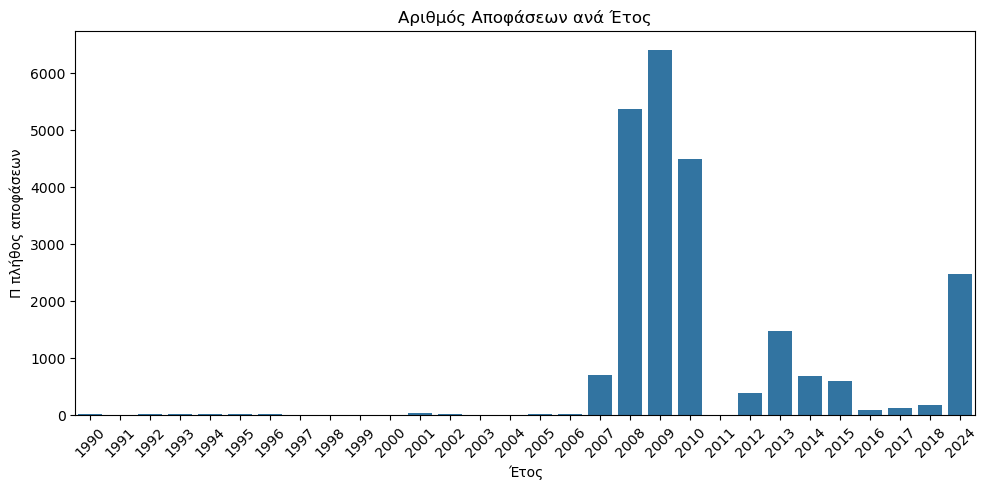

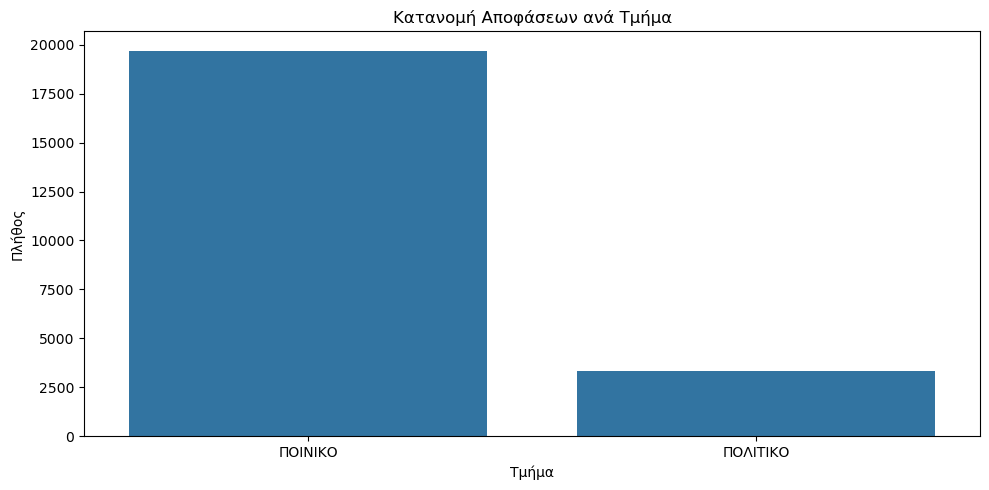

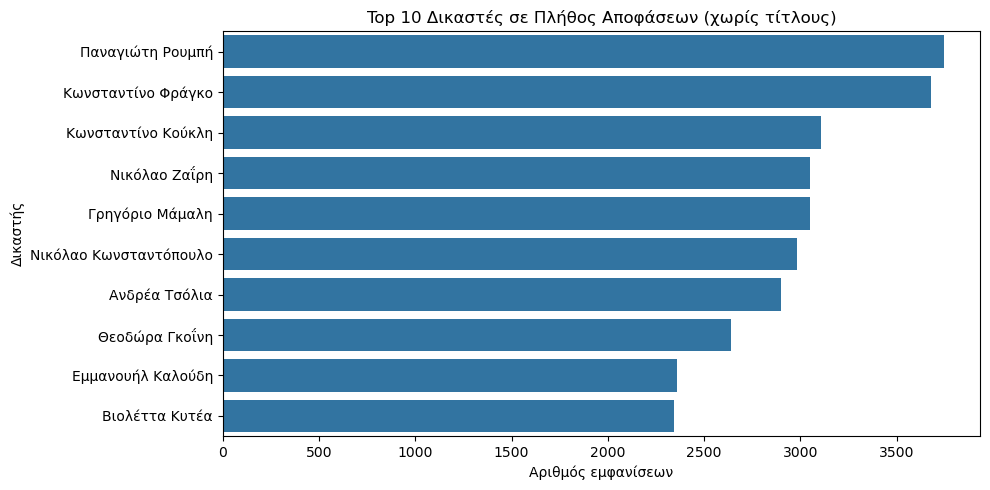

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from collections import Counter
import re

# --- 1. Αριθμός αποφάσεων ανά έτος ---
plt.figure(figsize=(10, 5))
sns.countplot(data=df_final, x="etos", order=sorted(df_final["etos"].dropna().unique()))
plt.title("Αριθμός Αποφάσεων ανά Έτος")
plt.xlabel("Έτος")
plt.ylabel("Π πλήθος αποφάσεων")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- 2. Αποφάσεις ανά τμήμα ---
plt.figure(figsize=(10, 5))
sns.countplot(data=df_final, x="tmima", order=df_final["tmima"].value_counts().index)
plt.title("Κατανομή Αποφάσεων ανά Τμήμα")
plt.xlabel("Τμήμα")
plt.ylabel("Πλήθος")
plt.tight_layout()
plt.show()

# --- 3. TOP 10 Άρθρα Π.Κ. και Κ.Π.Δ. για καθε eidos οπου το tmima == ΠΟΙΝΙΚΟ ---
df_poiniko = df_final[df_final["tmima"] == "ΠΟΙΝΙΚΟ"].copy()

def get_top10_articles_by_eidos(selected_eidos):
    filtered_df = df_poiniko[df_poiniko["eidos"] == selected_eidos]
    articles_list = filtered_df["poiniko_arithmos"].dropna().astype(str).str.split(";")
    flat_articles = [item.strip() for sublist in articles_list for item in sublist if item.strip()]
    article_counts = Counter(flat_articles)
    top10 = article_counts.most_common(10)
    return pd.DataFrame(top10, columns=["Άρθρο", "Συχνότητα"]).sort_values("Συχνότητα")

unique_eidos = df_poiniko["eidos"].dropna().unique()
initial_eidos = unique_eidos[0]
top10_df = get_top10_articles_by_eidos(initial_eidos)

fig = px.bar(
    top10_df,
    x="Συχνότητα",
    y="Άρθρο",
    orientation="h",
    color="Συχνότητα",
    color_continuous_scale="Viridis",
    title=f" Άρθρα Π.Κ. και Κ.Π.Δ. για: {initial_eidos} (μόνο ΠΟΙΝΙΚΟ)",
    labels={"Συχνότητα": "Εμφανίσεις", "Άρθρο": "Άρθρο Π.Κ. και Κ.Π.Δ."}
)

dropdown_buttons = []
for eidos_val in unique_eidos:
    filtered_df = get_top10_articles_by_eidos(eidos_val)
    dropdown_buttons.append(dict(
        method="update",
        label=eidos_val,
        args=[
            {
                "x": [filtered_df["Συχνότητα"]],
                "y": [filtered_df["Άρθρο"]],
                "marker.color": [filtered_df["Συχνότητα"]],
            },
            {
                "title.text": f"Άρθρα Π.Κ. και Κ.Π.Δ. για: {eidos_val} (μόνο ΠΟΙΝΙΚΟ)"
            }
        ]
    ))

fig.update_layout(
    width=1000,
    height=1000,
    updatemenus=[
        dict(
            active=0,
            buttons=dropdown_buttons,
            direction="down",
            showactive=True,
            x=0.0,
            y=1.15,
            xanchor="left",
            yanchor="top"
        )
    ],
    yaxis=dict(tickfont=dict(size=12)),
    xaxis=dict(title="Πλήθος Εμφανίσεων"),
    plot_bgcolor="white",
    coloraxis_showscale=False
)

fig.show()

# --- 4. TOP 10 Άρθρα Α.Κ. και Κ.Πολ.Δ. για καθε eidos που το tmima == ΠΟΛΙΤΙΚΟ ---
df_politiko = df_final[df_final["tmima"] == "ΠΟΛΙΤΙΚΟ"].copy()

def get_top10_articles_by_eidos(selected_eidos):
    filtered_df = df_politiko[df_politiko["eidos"] == selected_eidos]
    articles_list = filtered_df["politiko_arithmos"].dropna().astype(str).str.split(";")
    flat_articles = [item.strip() for sublist in articles_list for item in sublist if item.strip()]
    article_counts = Counter(flat_articles)
    top10 = article_counts.most_common(10)
    return pd.DataFrame(top10, columns=["Άρθρο", "Συχνότητα"]).sort_values("Συχνότητα")

unique_eidos = df_politiko["eidos"].dropna().unique()
initial_eidos = unique_eidos[0]
top10_df = get_top10_articles_by_eidos(initial_eidos)

fig = px.bar(
    top10_df,
    x="Συχνότητα",
    y="Άρθρο",
    orientation="h",
    color="Συχνότητα",
    color_continuous_scale="Viridis",
    title=f" Άρθρα Α.Κ. και Κ.Πολ.Δ. για: {initial_eidos} (μόνο ΠΟΛΙΤΙΚΟ)",
    labels={"Συχνότητα": "Εμφανίσεις", "Άρθρο": "Α.Κ. και Κ.Πολ.Δ."}
)

dropdown_buttons = []
for eidos_val in unique_eidos:
    filtered_df = get_top10_articles_by_eidos(eidos_val)
    dropdown_buttons.append(dict(
        method="update",
        label=eidos_val,
        args=[
            {
                "x": [filtered_df["Συχνότητα"]],
                "y": [filtered_df["Άρθρο"]],
                "marker.color": [filtered_df["Συχνότητα"]],
            },
            {
                "title.text": f"Άρθρα Α.Κ. και Κ.Πολ.Δ. για: {eidos_val} (μόνο ΠΟΛΙΤΙΚΟ)"
            }
        ]
    ))

fig.update_layout(
    width=1000,
    height=1000,
    updatemenus=[
        dict(
            active=0,
            buttons=dropdown_buttons,
            direction="down",
            showactive=True,
            x=0.0,
            y=1.15,
            xanchor="left",
            yanchor="top"
        )
    ],
    yaxis=dict(tickfont=dict(size=12)),
    xaxis=dict(title="Πλήθος Εμφανίσεων"),
    plot_bgcolor="white",
    coloraxis_showscale=False
)

fig.show()

# --- 5. Top 10 Δικαστές που εμφανίζονται συχνότερα ---
excluded_terms = [
    "Αρεοπαγίτες",
    "Αντιπρόεδρο Αρείου Πάγου",
    "Αντιπρόεδρο του Αρείου Πάγου"
]

all_judges = df_final["dikastes"].dropna().astype(str).apply(lambda x: re.split(r",| και ", x))
flat_judges = [
    j.strip() for sublist in all_judges for j in sublist
    if all(term not in j for term in excluded_terms)
]

top_judges = Counter(flat_judges).most_common(10)
judges_df = pd.DataFrame(top_judges, columns=["Δικαστής", "Συχνότητα"])

plt.figure(figsize=(10, 5))
sns.barplot(data=judges_df, x="Συχνότητα", y="Δικαστής")
plt.title("Top 10 Δικαστές σε Πλήθος Αποφάσεων (χωρίς τίτλους)")
plt.xlabel("Αριθμός εμφανίσεων")
plt.ylabel("Δικαστής")
plt.tight_layout()
plt.show()
